In [1]:
import os
import os.path as osp
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, IterableDataset
import random
import math
import string
import pandas as pd
import re
import nltk
import collections
import itertools
from nltk import tokenize, sent_tokenize
nltk.data.path.append(os.path.join(os.path.expanduser('~'), '.nltk_data'))
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/mtb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
dataset_path = os.getenv("DL_DATASET")

In [3]:
embedding_dataset_path =[osp.join(dataset_path, 
                                  f"OANC_GrAF/OANC-GrAF/data/written_1/journal/slate/{i}") 
                                  for i in range(1, 11)
                ]               

<h1> Load Data </h1>

In [4]:
files = []

for folder in embedding_dataset_path:
    for file_index in os.listdir(folder):
        if not file_index.endswith(".txt"):
            continue
        files.append(osp.join(folder, file_index))

In [5]:
len(files)

786

In [6]:
files = sorted(files)

In [7]:
files[0]

'/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/data/written_1/journal/slate/1/Article247_4.txt'

In [8]:
def read_file(filename):
    with open(filename, mode='r', encoding='utf-8') as f:
        return f.read()


In [9]:
read_file(files[0])

'\n   \n   \n      \n         \n            Harmonic Convergences\n            \n\n            You\'re right, Maxim\'s strong point is that it\'s totally unsentimental\nand ungenteel. It\'s a sendup of the old model, but in a different way than,\nsay, Hustler was, and the difference (surprise) reflects the sexual\nculture of the \'90s. With its belligerent grossness and misogyny,\nHustler rebelled against the establishment men\'s mags\' class\ncondescension, the earnest philosophizing about the sexual revolution, the\n"thinking men\'s sex bomb" syndrome, at the same time that it was deliberately\ngoading feminists. It came right out with the anger that the regular men\'s mags\ntried to hide. Maxim pokes fun at its progenitors but with considerable\nironic affection. It\'s not angry. In fact, while its fondness for the most\nidiotic, juvenile humor knows no bounds, any strong emotion is taboo (unless\nyou count horror at having your penis mangled)--that\'s part of the British\ninfluence

In [10]:
df_filenames, df_texts, df_paths = [], [], []

for filename in files:
    df_paths.append(filename)
    df_filenames.append(os.path.basename(filename))
    df_texts.append(read_file(filename))
ndf = pd.DataFrame({'path': df_paths,
                   'filename': df_filenames,
                   'text_raw': df_texts,
                   })
ndf


,path,filename,text_raw
0,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_4.txt,\n \n \n \n \n Har...
1,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_40.txt,\n \n \n \n \n All...
2,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_42.txt,\n \n \n \n \n Pic...
3,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_47.txt,\n \n \n \n \n The...
4,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_5.txt,\n \n \n \n \n Bad...
...,...,...,...
781,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_3295.txt,\n \n \n \n \n Wea...
782,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_3296.txt,\n \n \n \n \n ER:...
783,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_3297.txt,\n \n \n \n \n Is ...
784,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_3298.txt,\n \n \n \n \n No ...


In [11]:
sent_tokenize(ndf['text_raw'][0])

["\n   \n   \n      \n         \n            Harmonic Convergences\n            \n\n            You're right, Maxim's strong point is that it's totally unsentimental\nand ungenteel.",
 "It's a sendup of the old model, but in a different way than,\nsay, Hustler was, and the difference (surprise) reflects the sexual\nculture of the '90s.",
 'With its belligerent grossness and misogyny,\nHustler rebelled against the establishment men\'s mags\' class\ncondescension, the earnest philosophizing about the sexual revolution, the\n"thinking men\'s sex bomb" syndrome, at the same time that it was deliberately\ngoading feminists.',
 "It came right out with the anger that the regular men's mags\ntried to hide.",
 'Maxim pokes fun at its progenitors but with considerable\nironic affection.',
 "It's not angry.",
 "In fact, while its fondness for the most\nidiotic, juvenile humor knows no bounds, any strong emotion is taboo (unless\nyou count horror at having your penis mangled)--that's part of the B

In [12]:
df = []
for i in range(len(ndf)):
    tokenize_sent = sent_tokenize(ndf['text_raw'][i])
    _df = ndf.iloc[i: i+1,].copy(deep=True)
    _df = pd.concat([_df.copy(deep=True) for _  in range(len(tokenize_sent))]).reset_index()
    _df['text'] = tokenize_sent 
    df.append(_df)
df = pd.concat(df).reset_index()

In [13]:
df

,level_0,index,path,filename,text_raw,text
0,0,0,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_4.txt,\n \n \n \n \n Har...,\n \n \n \n \n Har...
1,1,0,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_4.txt,\n \n \n \n \n Har...,"It's a sendup of the old model, but in a diffe..."
2,2,0,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_4.txt,\n \n \n \n \n Har...,"With its belligerent grossness and misogyny,\n..."
3,3,0,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_4.txt,\n \n \n \n \n Har...,It came right out with the anger that the regu...
4,4,0,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_4.txt,\n \n \n \n \n Har...,Maxim pokes fun at its progenitors but with co...
...,...,...,...,...,...,...
22761,28,785,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_3299.txt,\n \n \n \n \n FDR...,"I never quite figured out, for\nexample, what ..."
22762,29,785,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_3299.txt,\n \n \n \n \n FDR...,"Poor Hick, bereft of career, living in\na perp..."
22763,30,785,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_3299.txt,\n \n \n \n \n FDR...,"Marjorie, it's been a delight to correspond wi..."
22764,31,785,/media/mtb/nas/datasets/OANC_GrAF/OANC-GrAF/da...,Article247_3299.txt,\n \n \n \n \n FDR...,Best wishes\nuntil we meet again--perhaps over...


<h1> Preprocess DATA </h1>

In [14]:
text = np.stack(df['text'].values)

In [15]:
text

array(["\n   \n   \n      \n         \n            Harmonic Convergences\n            \n\n            You're right, Maxim's strong point is that it's totally unsentimental\nand ungenteel.",
       "It's a sendup of the old model, but in a different way than,\nsay, Hustler was, and the difference (surprise) reflects the sexual\nculture of the '90s.",
       'With its belligerent grossness and misogyny,\nHustler rebelled against the establishment men\'s mags\' class\ncondescension, the earnest philosophizing about the sexual revolution, the\n"thinking men\'s sex bomb" syndrome, at the same time that it was deliberately\ngoading feminists.',
       ...,
       "Marjorie, it's been a delight to correspond with you this week.",
       'Best wishes\nuntil we meet again--perhaps over Volume 9 of some future 14-volume\nbiography of Rosalynn Carter.',
       'Yours,\n\n            Chris'], dtype='<U2573')

In [16]:
len(text)

22766

In [17]:
def preprocess_text(text):
    text = re.sub(r"\\n", " ", text)
    text = re.sub(r"\n", " ", text)
    text = text.translate(string.punctuation)
    
    text = text.lower().split()
    text = " ".join(text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\-\-", " ", text)
    text = re.sub(r"\-\s+\-", " ", text)
    text = re.sub(r"\s+\-\s+", "-", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    return text
    

df['text_preprocess'] = df['text'].apply(preprocess_text)

In [18]:
df['text_preprocess']

0        harmonic convergences you are right maxim stro...
1        it a sendup of the old model but in a differen...
2        with its belligerent grossness and misogyny hu...
3        it came right out with the anger that the regu...
4        maxim pokes fun at its progenitors but with co...
                               ...                        
22761    i never quite figured out for example what the...
22762    poor hick bereft of career living in a perpetu...
22763    marjorie it been a delight to correspond with ...
22764    best wishes until we meet again perhaps over v...
22765                                          yours chris
Name: text_preprocess, Length: 22766, dtype: object

In [19]:
# for i in range(len(df['text_preprocess'])):
#     sentence = df['text_preprocess'].iloc[i]
#     if '-' in sentence:
#         print(sentence)
    

In [20]:
corpus = df['text_preprocess'].tolist()

In [21]:
len(corpus)

22766

In [22]:
words = [tokenize.word_tokenize(x) for x in corpus]

In [23]:
words[0]

['harmonic',
 'convergences',
 'you',
 'are',
 'right',
 'maxim',
 'strong',
 'point',
 'is',
 'that',
 'it',
 'totally',
 'unsentimental',
 'and',
 'ungenteel']

In [24]:
counter = collections.Counter(np.concatenate(words))

In [25]:
counter['the']

40195

In [26]:
counter['and']


10758

In [27]:
voc_df = pd.DataFrame([counter]).T.reset_index()
voc_df.columns = ['words','count']
voc_df = voc_df.sort_values(by='count', ascending=False).reset_index(drop=True)

In [28]:
voc_df

,words,count
0,the,40195
1,of,13685
2,to,12709
3,a,11872
4,and,10758
...,...,...
30050,discriminatory,1
30051,andie,1
30052,macdowell,1
30053,withdrawn,1


<AxesSubplot: xlabel='words'>

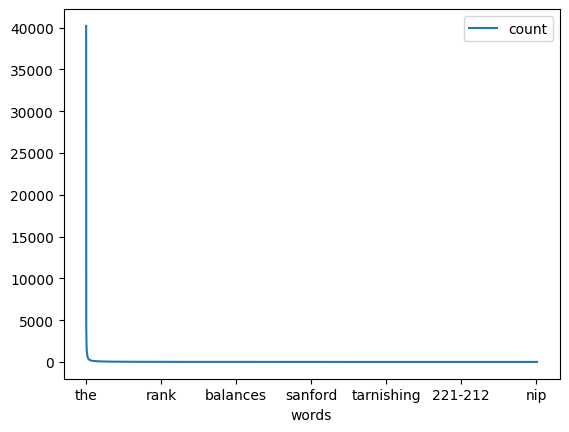

In [29]:
voc_df.sort_values(by='count', ascending=False).plot(x='words')

In [30]:
voc_df

,words,count
0,the,40195
1,of,13685
2,to,12709
3,a,11872
4,and,10758
...,...,...
30050,discriminatory,1
30051,andie,1
30052,macdowell,1
30053,withdrawn,1


In [31]:
voc_df.to_csv('./data.csv')

<h1> Model DATA processing </h1>

In [32]:
class Vocabulary:
    SPECIAL_CHARS =['<unk>']
    def __init__(self, corpus, min_freq=None, special_chars="unk") -> None:
        self.corpus = corpus
        self.special_chars = special_chars
        self.sentences = [tokenize.word_tokenize(sentence)
                                            for sentence in corpus]
        self.counter = collections.Counter(np.concatenate(self.sentences))
        self.voc_df = self.get_vocab_df(self.counter)
        self.min_freq = min_freq 
        
        self.token_dict = {}       
        self.idx_dict = {}       
    
    def __getitem__(self, index):
        pass
    
    def __len__(self):
        return len(self.voc_df)

    def get_vocab_df(self, counter):
        voc_df = pd.DataFrame([counter]).T.reset_index()
        voc_df.columns = ['token','count']
        voc_df = voc_df.sort_values(by='count', ascending=False).reset_index(drop=True)
        
        return voc_df

    def preprocess(self):
        condition = self.voc_df['count'] >= self.min_freq
        unk_count = self.voc_df.loc[~condition, "count"].sum()
        trunc_voc_df = self.voc_df[condition].copy().reset_index(drop=True)
        
        self.trunc_voc_df = trunc_voc_df
        
        trunc_voc_df.loc[:, 'idx'] = trunc_voc_df.index + 1
        
        trunc_voc_df = pd.concat([trunc_voc_df,
                                  pd.DataFrame({"idx": [0], 
                                                 "token": [self.special_chars],
                                                 "count": [unk_count]
                                                 }
                                               )
                                  ]).reset_index(drop=True)
        
        self.counter = dict(zip(trunc_voc_df ['token'], trunc_voc_df['count']))
        
        
        self.token_dict = dict(zip(trunc_voc_df['token'],
                                  trunc_voc_df['idx'],
                                  ))    
        self.idx_dict = dict(zip(trunc_voc_df['idx'],
                                  trunc_voc_df['token'],
                                  ))        
        self.voc_df = trunc_voc_df
        
        self.sentences = [[token if token in self.token_dict else self.special_chars 
                           for token in tokens] 
                          for tokens in self.sentences]
        
    def get_token(self, index):
        return self.tokens[index]
    
    def idx_to_token(self, idx):
        return [self.idx_dict[id] for id in idx]
    
    def token_to_idx(self, tokens):
        return [self.token_dict[token] if token in self.token_dict else -1 
                for token in tokens]
        
        


In [33]:
vocab = Vocabulary(corpus, min_freq=5)

In [34]:
vocab.voc_df

,token,count
0,the,40195
1,of,13685
2,to,12709
3,a,11872
4,and,10758
...,...,...
30050,discriminatory,1
30051,andie,1
30052,macdowell,1
30053,withdrawn,1


In [35]:
vocab.voc_df['count'].sum()

522615

In [36]:
vocab.preprocess()

In [37]:
vocab.voc_df

,token,count,idx
0,the,40195,1
1,of,13685,2
2,to,12709,3
3,a,11872,4
4,and,10758,5
...,...,...,...
8122,shortest,5,8123
8123,misdeeds,5,8124
8124,packing,5,8125
8125,insurrection,5,8126


In [38]:
vocab.voc_df['count'].sum()

522615

In [39]:
vocab.sentences[0], corpus[0]

(['unk',
  'unk',
  'you',
  'are',
  'right',
  'maxim',
  'strong',
  'point',
  'is',
  'that',
  'it',
  'totally',
  'unk',
  'and',
  'unk'],
 'harmonic convergences you are right maxim strong point is that it totally unsentimental and ungenteel ')

In [40]:
class NegativeSampling:
    
    def __init__(self, weights) -> None:
        self.weights = weights
        self.population = list(range(1, len(self.weights) + 1))
        self.candidate = []
        self.i = 0
    def sample(self):
        if self.i == len(self.candidate):
            self.candidate = random.choices(self.population, self.weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidate[self.i - 1]
        
        

In [41]:
def extract_contexts_and_center(sentences, unk_char="unk", max_window_size=5):
    centers, contexts = [], []
    for tokens in sentences:
        if len(tokens) < 2:
            continue
        for i in range(len(tokens)):
            token = tokens[i]
            if token == unk_char:
                continue
            window_size = random.randint(1, max_window_size)
            low, high = max(0, i - window_size), min(i + 1 + window_size, len(tokens))
            indices = list(range(low, i)) + list(range(i+1, high))
            
            values = [tokens[idx] for idx in indices if tokens[idx] != unk_char]
            if values:
                contexts.append(values)
                centers.append(token)
        
    return centers, contexts

In [42]:
vocab = Vocabulary(corpus, min_freq=5)
vocab.preprocess()

In [43]:
centers, contexts = extract_contexts_and_center(vocab.sentences[-2:])


In [44]:
centers, contexts

(['best',
  'wishes',
  'until',
  'we',
  'meet',
  'again',
  'perhaps',
  'over',
  'volume',
  '9',
  'of',
  'some',
  'future',
  'biography',
  'of',
  'yours',
  'chris'],
 [['wishes'],
  ['best', 'until', 'we', 'meet'],
  ['best', 'wishes', 'we', 'meet', 'again', 'perhaps', 'over'],
  ['wishes', 'until', 'meet', 'again'],
  ['wishes', 'until', 'we', 'again', 'perhaps', 'over'],
  ['best',
   'wishes',
   'until',
   'we',
   'meet',
   'perhaps',
   'over',
   'volume',
   '9',
   'of'],
  ['meet', 'again', 'over', 'volume'],
  ['perhaps', 'volume'],
  ['we', 'meet', 'again', 'perhaps', 'over', '9', 'of', 'some', 'future'],
  ['perhaps', 'over', 'volume', 'of', 'some', 'future'],
  ['over', 'volume', '9', 'some', 'future'],
  ['of', 'future'],
  ['some'],
  ['9', 'of', 'some', 'future', 'of', 'carter'],
  ['biography'],
  ['chris'],
  ['yours']])

In [45]:
def get_negatives(contexts, vocab, k=5):  
    voc_df = vocab.voc_df[vocab.voc_df['token'] != "unk"].copy()
    voc_df['sampling_weights'] = voc_df['count'] ** 0.75
    generator = NegativeSampling(voc_df['sampling_weights'].tolist())
    contexts_negatives = []
    for context in contexts:
        context_negative = []
        while len(context_negative) < k:
            idx = generator.sample()
            token = vocab.idx_to_token([idx])[0]
            if token in context:
                continue
            context_negative.append(token)
        contexts_negatives.append(context_negative)
    
    return contexts_negatives
negatives = get_negatives(contexts, vocab)

In [46]:
def load_data(corpus):
    vocab = Vocabulary(corpus, min_freq=5)
    vocab.preprocess()
    centers, contexts = extract_contexts_and_center(vocab.sentences)
    negatives = get_negatives(contexts, vocab)
    
    return vocab, centers, contexts, negatives
    

In [47]:
vocab, centers, contexts, negatives = load_data(corpus)
num_classes = len(vocab)

In [48]:
len(centers), len(contexts), len(negatives)

(486189, 486189, 486189)

In [49]:
centers[0], contexts[0], negatives[0]

('you', ['are', 'right'], ['dangerous', '209', 'to', 'him', 'operations'])

In [50]:
class OANCDataset(Dataset):
    
    def __init__(self, centers, contexts, negatives) -> None:
        self.centers = centers
        self.contexts = contexts
        self.negatives = negatives
    
    def __getitem__(self, index):
        return (self.centers[index], self.contexts[index],
                self.negatives[index])

    def __len__(self):
        return len(self.centers)


In [51]:
def collate_fn(data):
    centers, contexts, masks, labels = [], [], [], []
    max_len = max(len(co) + len(neg) for ce, co, neg in data)
    for center, context, negative in data:
        centers.append(vocab.token_to_idx([center]))
        contexts.append([vocab.token_to_idx([c])[0] for c in context] + \
                        [vocab.token_to_idx([c])[0] for c in negative] + \
                        [0] * (max_len - len(context) - len(negative)))
        masks.append(
            [1] * (len(context) + len(negative)) + [0] * (max_len - len(context) - len(negative))
        )
        labels.append(
            [1] * len(context) + [0] * (max_len - len(context))
        )
    return (torch.tensor(centers, dtype=torch.int64),
            torch.tensor(contexts, dtype=torch.long),
            torch.tensor(masks, dtype=torch.long),
            torch.tensor(labels, dtype=torch.long)
    )
  

In [52]:
dataset = OANCDataset(centers, contexts, negatives)

In [53]:
len(dataset)

486189

In [54]:
486229 / 128

3798.6640625

In [55]:
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)

In [56]:
data = next(iter(dataloader))

In [57]:
data[1][:10], data[1].shape

(tensor([[ 222,  168, 4526, 4195,  109,  228,  505,    0,    0,    0,    0,    0,
             0,    0,    0],
         [5802,    1, 6858,  643,  127,  601, 6379,    0,    0,    0,    0,    0,
             0,    0,    0],
         [1370,   59, 2599, 1988,  607,  693, 1866,    0,    0,    0,    0,    0,
             0,    0,    0],
         [2634,   52,    6,   13,    8,    1,  783, 3498,    2, 2533, 1597, 3721,
          8055, 4372,    0],
         [ 117, 1250,   20, 4354,   87,  106, 6919,  636,   21,   12,    0,    0,
             0,    0,    0],
         [1918,  484,  352, 2995,  783, 5191,  157,    0,    0,    0,    0,    0,
             0,    0,    0],
         [ 768,    1,   62, 3108,   25, 5367,   10,    5,    0,    0,    0,    0,
             0,    0,    0],
         [  31,  180,  520,  131, 1405,  243, 7413,   29,    2,    0,    0,    0,
             0,    0,    0],
         [   9,  671,    6,    9,  574,    6, 2081,   81,   12, 6933, 3822,   73,
            31,   88,  582],
 

In [58]:
test_data = F.one_hot(data[1], num_classes)
test_data.shape

torch.Size([128, 15, 8127])

In [59]:
nn.Embedding(num_embeddings=num_classes,
             embedding_dim=300)(data[1]).shape


torch.Size([128, 15, 300])

In [60]:
data[0].shape

torch.Size([128, 1])

In [61]:
nn.Embedding(num_embeddings=num_classes,
             embedding_dim=300)(data[0]).shape

torch.Size([128, 1, 300])

In [62]:
class SkipGram(nn.Module):
    
    def __init__(self, num_classes, hidden_size=10) -> None:
        super().__init__()
        self.embed_v = nn.Embedding(num_classes, embedding_dim=hidden_size)
        self.embed_u = nn.Embedding(num_classes, embedding_dim=hidden_size)
        self.initialize()
    
    def initialize(self,):
        with torch.no_grad():
            nn.init.kaiming_normal_(self.embed_u.weight)    
            nn.init.normal_(self.embed_v.weight)
    
    def forward(self, centers, contexts_and_negatives):
        v = self.embed_v(centers)
        u = self.embed_u(contexts_and_negatives)
        pred = torch.bmm(v, u.permute(0, 2, 1)).squeeze(dim=1)
        return pred


In [67]:
class BinaryLoss(nn.Module):
    
    def __init__(self) -> None:
        super().__init__()
    
    def forward(self, input, target, mask=None):
        return F.binary_cross_entropy_with_logits(input, target, weight=mask, reduction="none").mean(dim=1)

In [78]:
device = torch.device('cuda')
net = SkipGram(num_classes, hidden_size=512).to(device=device)
loss_fn = BinaryLoss()

In [79]:
optimizer = torch.optim.Adam(params=net.parameters(),
                             lr=0.001
                             )
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.998)
net.train()

SkipGram(
  (embed_v): Embedding(8127, 512)
  (embed_u): Embedding(8127, 512)
)

In [80]:
dataloader = DataLoader(dataset, batch_size=512, 
                        shuffle=True, collate_fn=collate_fn, num_workers=4)

In [81]:
it, losses = 0, []
for epoch in range(500):
    for i, batch_data in enumerate(dataloader):
        center, context, mask, label = [data.to(device) for data in batch_data]
        pred = net(center, context)
        loss = loss_fn(pred, label.float(), mask).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step(epoch)
        
        losses.append(float(loss.item()))
        it += 1
        if it % 100 == 0:
            print(f"Epoch: {epoch}, it: {it}, loss: {loss.item()}, lr: {scheduler.get_last_lr()[0]}")
            
        

Epoch: 0, it: 100, loss: 0.550422191619873, lr: 0.001
Epoch: 0, it: 200, loss: 0.5317054986953735, lr: 0.001
Epoch: 0, it: 300, loss: 0.501706063747406, lr: 0.001
Epoch: 0, it: 400, loss: 0.5139716863632202, lr: 0.001
Epoch: 0, it: 500, loss: 0.4952424168586731, lr: 0.001
Epoch: 0, it: 600, loss: 0.49612361192703247, lr: 0.001
Epoch: 0, it: 700, loss: 0.5012005567550659, lr: 0.001
Epoch: 0, it: 800, loss: 0.4932002127170563, lr: 0.001
Epoch: 0, it: 900, loss: 0.49815982580184937, lr: 0.001
Epoch: 1, it: 1000, loss: 0.3808949887752533, lr: 0.000998
Epoch: 1, it: 1100, loss: 0.383221298456192, lr: 0.000998
Epoch: 1, it: 1200, loss: 0.38990193605422974, lr: 0.000998
Epoch: 1, it: 1300, loss: 0.3948889374732971, lr: 0.000998
Epoch: 1, it: 1400, loss: 0.3963511288166046, lr: 0.000998
Epoch: 1, it: 1500, loss: 0.3998216390609741, lr: 0.000998
Epoch: 1, it: 1600, loss: 0.39221248030662537, lr: 0.000998
Epoch: 1, it: 1700, loss: 0.3979899287223816, lr: 0.000998
Epoch: 1, it: 1800, loss: 0.3959

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):


  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
Traceback (most recent call last):
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
self._shutdown_workers()
          File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
self._shutdown_workers()self._shutdown_workers()

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_w

Epoch: 219, it: 209000, loss: 0.22863472998142242, lr: 0.0006450428147852287
Epoch: 220, it: 209100, loss: 0.23181280493736267, lr: 0.0006437527291556583
Epoch: 220, it: 209200, loss: 0.22899961471557617, lr: 0.0006437527291556583
Epoch: 220, it: 209300, loss: 0.22606468200683594, lr: 0.0006437527291556583
Epoch: 220, it: 209400, loss: 0.2458176612854004, lr: 0.0006437527291556583
Epoch: 220, it: 209500, loss: 0.2386336475610733, lr: 0.0006437527291556583
Epoch: 220, it: 209600, loss: 0.2503092586994171, lr: 0.0006437527291556583
Epoch: 220, it: 209700, loss: 0.2404519021511078, lr: 0.0006437527291556583
Epoch: 220, it: 209800, loss: 0.2514485716819763, lr: 0.0006437527291556583
Epoch: 220, it: 209900, loss: 0.23999789357185364, lr: 0.0006437527291556583


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 221, it: 210000, loss: 0.23588894307613373, lr: 0.0006424652236973469
Epoch: 221, it: 210100, loss: 0.238459512591362, lr: 0.0006424652236973469
Epoch: 221, it: 210200, loss: 0.22875504195690155, lr: 0.0006424652236973469
Epoch: 221, it: 210300, loss: 0.24227529764175415, lr: 0.0006424652236973469
Epoch: 221, it: 210400, loss: 0.23493334650993347, lr: 0.0006424652236973469
Epoch: 221, it: 210500, loss: 0.23724520206451416, lr: 0.0006424652236973469
Epoch: 221, it: 210600, loss: 0.23053082823753357, lr: 0.0006424652236973469
Epoch: 221, it: 210700, loss: 0.23342233896255493, lr: 0.0006424652236973469
Epoch: 221, it: 210800, loss: 0.238075852394104, lr: 0.0006424652236973469
Epoch: 221, it: 210900, loss: 0.25787946581840515, lr: 0.0006424652236973469
Epoch: 222, it: 211000, loss: 0.2338564246892929, lr: 0.0006411802932499523
Epoch: 222, it: 211100, loss: 0.24461662769317627, lr: 0.0006411802932499523
Epoch: 222, it: 211200, loss: 0.23458096385002136, lr: 0.0006411802932499523
Epoc

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

Traceback (most recent call last):
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    self._shutdown_workers()    
if w.is_alive():
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.9/multiprocessing/pr

Epoch: 223, it: 211900, loss: 0.22344060242176056, lr: 0.0006398979326634524
Epoch: 223, it: 212000, loss: 0.2455807328224182, lr: 0.0006398979326634524
Epoch: 223, it: 212100, loss: 0.23594391345977783, lr: 0.0006398979326634524
Epoch: 223, it: 212200, loss: 0.230367049574852, lr: 0.0006398979326634524
Epoch: 223, it: 212300, loss: 0.2324916124343872, lr: 0.0006398979326634524
Epoch: 223, it: 212400, loss: 0.23719637095928192, lr: 0.0006398979326634524
Epoch: 223, it: 212500, loss: 0.2380937933921814, lr: 0.0006398979326634524
Epoch: 223, it: 212600, loss: 0.24016770720481873, lr: 0.0006398979326634524
Epoch: 223, it: 212700, loss: 0.24163314700126648, lr: 0.0006398979326634524


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Exception ignored in: Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Exception ignored in:   File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__


<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):
Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
self._shutdown_workers()      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

self._shutdown_workers()    
      File "/home/

Epoch: 223, it: 212800, loss: 0.25327080488204956, lr: 0.0006398979326634524
Epoch: 224, it: 212900, loss: 0.21635425090789795, lr: 0.0006386181367981255
Epoch: 224, it: 213000, loss: 0.22221995890140533, lr: 0.0006386181367981255
Epoch: 224, it: 213100, loss: 0.224100261926651, lr: 0.0006386181367981255
Epoch: 224, it: 213200, loss: 0.24016639590263367, lr: 0.0006386181367981255
Epoch: 224, it: 213300, loss: 0.24796843528747559, lr: 0.0006386181367981255
Epoch: 224, it: 213400, loss: 0.24913062155246735, lr: 0.0006386181367981255
Epoch: 224, it: 213500, loss: 0.24524863064289093, lr: 0.0006386181367981255
Epoch: 224, it: 213600, loss: 0.23768289387226105, lr: 0.0006386181367981255
Epoch: 224, it: 213700, loss: 0.23726040124893188, lr: 0.0006386181367981255


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 225, it: 213800, loss: 0.22500629723072052, lr: 0.0006373409005245292
Epoch: 225, it: 213900, loss: 0.2344801425933838, lr: 0.0006373409005245292
Epoch: 225, it: 214000, loss: 0.23156192898750305, lr: 0.0006373409005245292
Epoch: 225, it: 214100, loss: 0.24005919694900513, lr: 0.0006373409005245292
Epoch: 225, it: 214200, loss: 0.22292283177375793, lr: 0.0006373409005245292
Epoch: 225, it: 214300, loss: 0.23080837726593018, lr: 0.0006373409005245292
Epoch: 225, it: 214400, loss: 0.2511844038963318, lr: 0.0006373409005245292
Epoch: 225, it: 214500, loss: 0.24847902357578278, lr: 0.0006373409005245292
Epoch: 225, it: 214600, loss: 0.251041978597641, lr: 0.0006373409005245292
Epoch: 225, it: 214700, loss: 0.24773314595222473, lr: 0.0006373409005245292
Epoch: 226, it: 214800, loss: 0.2377835512161255, lr: 0.0006360662187234801
Epoch: 226, it: 214900, loss: 0.23254720866680145, lr: 0.0006360662187234801
Epoch: 226, it: 215000, loss: 0.24128280580043793, lr: 0.0006360662187234801
Epoc

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
Exception ignored in:   File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>    self._shutdown_workers()

Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    if w.is_alive():    
self._shutdown_workers()  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive

      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'
    AssertionErrorif w.is_alive():Exception ignored in: : 
<function _M

Epoch: 226, it: 215600, loss: 0.25090327858924866, lr: 0.0006360662187234801
Epoch: 227, it: 215700, loss: 0.22570618987083435, lr: 0.0006347940862860332
Epoch: 227, it: 215800, loss: 0.23423057794570923, lr: 0.0006347940862860332
Epoch: 227, it: 215900, loss: 0.2321070432662964, lr: 0.0006347940862860332
Epoch: 227, it: 216000, loss: 0.2316616028547287, lr: 0.0006347940862860332
Epoch: 227, it: 216100, loss: 0.22641263902187347, lr: 0.0006347940862860332
Epoch: 227, it: 216200, loss: 0.23577001690864563, lr: 0.0006347940862860332
Epoch: 227, it: 216300, loss: 0.2523956298828125, lr: 0.0006347940862860332
Epoch: 227, it: 216400, loss: 0.225200355052948, lr: 0.0006347940862860332
Epoch: 227, it: 216500, loss: 0.23887735605239868, lr: 0.0006347940862860332


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    
    self._shutdown_workers()Traceback (most recent call last):
if w.is_alive():  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__


Exception ignored in:   File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, 

Epoch: 227, it: 216600, loss: 0.23438391089439392, lr: 0.0006347940862860332
Epoch: 228, it: 216700, loss: 0.23867037892341614, lr: 0.0006335244981134612
Epoch: 228, it: 216800, loss: 0.22612643241882324, lr: 0.0006335244981134612
Epoch: 228, it: 216900, loss: 0.22357501089572906, lr: 0.0006335244981134612
Epoch: 228, it: 217000, loss: 0.23908878862857819, lr: 0.0006335244981134612
Epoch: 228, it: 217100, loss: 0.23736244440078735, lr: 0.0006335244981134612
Epoch: 228, it: 217200, loss: 0.23653927445411682, lr: 0.0006335244981134612
Epoch: 228, it: 217300, loss: 0.24065646529197693, lr: 0.0006335244981134612
Epoch: 228, it: 217400, loss: 0.2462073266506195, lr: 0.0006335244981134612


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 228, it: 217500, loss: 0.25251513719558716, lr: 0.0006335244981134612
Epoch: 229, it: 217600, loss: 0.22741535305976868, lr: 0.0006322574491172343
Epoch: 229, it: 217700, loss: 0.23061048984527588, lr: 0.0006322574491172343
Epoch: 229, it: 217800, loss: 0.22867892682552338, lr: 0.0006322574491172343
Epoch: 229, it: 217900, loss: 0.22486576437950134, lr: 0.0006322574491172343
Epoch: 229, it: 218000, loss: 0.23870301246643066, lr: 0.0006322574491172343
Epoch: 229, it: 218100, loss: 0.23149839043617249, lr: 0.0006322574491172343
Epoch: 229, it: 218200, loss: 0.2545959949493408, lr: 0.0006322574491172343
Epoch: 229, it: 218300, loss: 0.23304173350334167, lr: 0.0006322574491172343
Epoch: 229, it: 218400, loss: 0.24444210529327393, lr: 0.0006322574491172343
Epoch: 229, it: 218500, loss: 0.22320236265659332, lr: 0.0006322574491172343
Epoch: 230, it: 218600, loss: 0.2318415492773056, lr: 0.0006309929342189997
Epoch: 230, it: 218700, loss: 0.23936742544174194, lr: 0.0006309929342189997
E

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()self._shutdown_workers()
    
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_wo

Epoch: 230, it: 219400, loss: 0.2466500848531723, lr: 0.0006309929342189997
Epoch: 231, it: 219500, loss: 0.22400258481502533, lr: 0.0006297309483505618
Epoch: 231, it: 219600, loss: 0.2436906099319458, lr: 0.0006297309483505618
Epoch: 231, it: 219700, loss: 0.23218049108982086, lr: 0.0006297309483505618
Epoch: 231, it: 219800, loss: 0.23344722390174866, lr: 0.0006297309483505618
Epoch: 231, it: 219900, loss: 0.24595199525356293, lr: 0.0006297309483505618
Epoch: 231, it: 220000, loss: 0.24820326268672943, lr: 0.0006297309483505618
Epoch: 231, it: 220100, loss: 0.22452539205551147, lr: 0.0006297309483505618
Epoch: 231, it: 220200, loss: 0.2279716283082962, lr: 0.0006297309483505618


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>    
Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
Traceback (most recent call last):

self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):

          Fi

Epoch: 231, it: 220300, loss: 0.2452077865600586, lr: 0.0006297309483505618
Epoch: 231, it: 220400, loss: 0.24178437888622284, lr: 0.0006297309483505618
Epoch: 232, it: 220500, loss: 0.22612573206424713, lr: 0.0006284714864538606
Epoch: 232, it: 220600, loss: 0.23163622617721558, lr: 0.0006284714864538606
Epoch: 232, it: 220700, loss: 0.23368018865585327, lr: 0.0006284714864538606
Epoch: 232, it: 220800, loss: 0.23162323236465454, lr: 0.0006284714864538606
Epoch: 232, it: 220900, loss: 0.2406739741563797, lr: 0.0006284714864538606
Epoch: 232, it: 221000, loss: 0.23572033643722534, lr: 0.0006284714864538606
Epoch: 232, it: 221100, loss: 0.24761533737182617, lr: 0.0006284714864538606
Epoch: 232, it: 221200, loss: 0.23809020221233368, lr: 0.0006284714864538606


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 232, it: 221300, loss: 0.23054081201553345, lr: 0.0006284714864538606
Epoch: 233, it: 221400, loss: 0.22641393542289734, lr: 0.0006272145434809529
Epoch: 233, it: 221500, loss: 0.24422608315944672, lr: 0.0006272145434809529
Epoch: 233, it: 221600, loss: 0.2357797771692276, lr: 0.0006272145434809529
Epoch: 233, it: 221700, loss: 0.22370444238185883, lr: 0.0006272145434809529
Epoch: 233, it: 221800, loss: 0.24269577860832214, lr: 0.0006272145434809529
Epoch: 233, it: 221900, loss: 0.2364916056394577, lr: 0.0006272145434809529
Epoch: 233, it: 222000, loss: 0.2395883947610855, lr: 0.0006272145434809529
Epoch: 233, it: 222100, loss: 0.24234136939048767, lr: 0.0006272145434809529
Epoch: 233, it: 222200, loss: 0.23988820612430573, lr: 0.0006272145434809529
Epoch: 233, it: 222300, loss: 0.2597182095050812, lr: 0.0006272145434809529
Epoch: 234, it: 222400, loss: 0.22359248995780945, lr: 0.0006259601143939911
Epoch: 234, it: 222500, loss: 0.2330401986837387, lr: 0.0006259601143939911
Epoc

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getp

Epoch: 234, it: 223200, loss: 0.24640502035617828, lr: 0.0006259601143939911
Epoch: 235, it: 223300, loss: 0.23929303884506226, lr: 0.000624708194165203
Epoch: 235, it: 223400, loss: 0.21855813264846802, lr: 0.000624708194165203
Epoch: 235, it: 223500, loss: 0.23683685064315796, lr: 0.000624708194165203
Epoch: 235, it: 223600, loss: 0.223528191447258, lr: 0.000624708194165203
Epoch: 235, it: 223700, loss: 0.23674283921718597, lr: 0.000624708194165203
Epoch: 235, it: 223800, loss: 0.24351252615451813, lr: 0.000624708194165203
Epoch: 235, it: 223900, loss: 0.23064979910850525, lr: 0.000624708194165203
Epoch: 235, it: 224000, loss: 0.24118870496749878, lr: 0.000624708194165203


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
if w.is_alive():
      File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/local/lib/python3.9/multiprocessing/p

Epoch: 235, it: 224100, loss: 0.25360602140426636, lr: 0.000624708194165203
Epoch: 235, it: 224200, loss: 0.2540258765220642, lr: 0.000624708194165203
Epoch: 236, it: 224300, loss: 0.23156142234802246, lr: 0.0006234587777768725
Epoch: 236, it: 224400, loss: 0.2193220555782318, lr: 0.0006234587777768725
Epoch: 236, it: 224500, loss: 0.23674362897872925, lr: 0.0006234587777768725
Epoch: 236, it: 224600, loss: 0.24045468866825104, lr: 0.0006234587777768725
Epoch: 236, it: 224700, loss: 0.23243369162082672, lr: 0.0006234587777768725
Epoch: 236, it: 224800, loss: 0.24437442421913147, lr: 0.0006234587777768725
Epoch: 236, it: 224900, loss: 0.23554149270057678, lr: 0.0006234587777768725
Epoch: 236, it: 225000, loss: 0.244521826505661, lr: 0.0006234587777768725


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 236, it: 225100, loss: 0.2504928708076477, lr: 0.0006234587777768725
Epoch: 237, it: 225200, loss: 0.24183428287506104, lr: 0.0006222118602213188
Epoch: 237, it: 225300, loss: 0.22698773443698883, lr: 0.0006222118602213188
Epoch: 237, it: 225400, loss: 0.23989816009998322, lr: 0.0006222118602213188
Epoch: 237, it: 225500, loss: 0.23271910846233368, lr: 0.0006222118602213188
Epoch: 237, it: 225600, loss: 0.23393437266349792, lr: 0.0006222118602213188
Epoch: 237, it: 225700, loss: 0.2236384153366089, lr: 0.0006222118602213188
Epoch: 237, it: 225800, loss: 0.24499835073947906, lr: 0.0006222118602213188
Epoch: 237, it: 225900, loss: 0.2370355725288391, lr: 0.0006222118602213188
Epoch: 237, it: 226000, loss: 0.24570831656455994, lr: 0.0006222118602213188
Epoch: 237, it: 226100, loss: 0.24325424432754517, lr: 0.0006222118602213188
Epoch: 238, it: 226200, loss: 0.22285741567611694, lr: 0.0006209674365008762
Epoch: 238, it: 226300, loss: 0.2307361662387848, lr: 0.0006209674365008762
Epo

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: Exception ignored in: can only test a child process<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 238, it: 226900, loss: 0.23288267850875854, lr: 0.0006209674365008762
Epoch: 238, it: 227000, loss: 0.24728569388389587, lr: 0.0006209674365008762
Epoch: 239, it: 227100, loss: 0.22578293085098267, lr: 0.0006197255016278744
Epoch: 239, it: 227200, loss: 0.23225417733192444, lr: 0.0006197255016278744
Epoch: 239, it: 227300, loss: 0.22672343254089355, lr: 0.0006197255016278744
Epoch: 239, it: 227400, loss: 0.23508352041244507, lr: 0.0006197255016278744
Epoch: 239, it: 227500, loss: 0.24533642828464508, lr: 0.0006197255016278744
Epoch: 239, it: 227600, loss: 0.23269352316856384, lr: 0.0006197255016278744
Epoch: 239, it: 227700, loss: 0.24878863990306854, lr: 0.0006197255016278744
Epoch: 239, it: 227800, loss: 0.25308042764663696, lr: 0.0006197255016278744


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>self._shutdown_workers()Traceback (most recent call last):


  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        if w.is_alive():self._shutdown_workers()Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

        Traceback (most recent call last):
assert self._p

Epoch: 239, it: 227900, loss: 0.25780123472213745, lr: 0.0006197255016278744
Epoch: 239, it: 228000, loss: 0.23727357387542725, lr: 0.0006197255016278744
Epoch: 240, it: 228100, loss: 0.23726323246955872, lr: 0.0006184860506246187
Epoch: 240, it: 228200, loss: 0.2275238037109375, lr: 0.0006184860506246187
Epoch: 240, it: 228300, loss: 0.2296580970287323, lr: 0.0006184860506246187
Epoch: 240, it: 228400, loss: 0.24373957514762878, lr: 0.0006184860506246187
Epoch: 240, it: 228500, loss: 0.23609605431556702, lr: 0.0006184860506246187
Epoch: 240, it: 228600, loss: 0.2381613552570343, lr: 0.0006184860506246187
Epoch: 240, it: 228700, loss: 0.2441079318523407, lr: 0.0006184860506246187
Epoch: 240, it: 228800, loss: 0.25529786944389343, lr: 0.0006184860506246187
Epoch: 240, it: 228900, loss: 0.24611935019493103, lr: 0.0006184860506246187
Epoch: 241, it: 229000, loss: 0.22932499647140503, lr: 0.0006172490785233694
Epoch: 241, it: 229100, loss: 0.2260940968990326, lr: 0.0006172490785233694
Epoc

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):

      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
self._shutdown_workers()Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
self._shutdown_workers()        
self._shutdown_workers()if w.is_alive():  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1

Epoch: 242, it: 230700, loss: 0.2436298131942749, lr: 0.0006160145803663227
Epoch: 242, it: 230800, loss: 0.2523084282875061, lr: 0.0006160145803663227
Epoch: 243, it: 230900, loss: 0.22009271383285522, lr: 0.0006147825512055901
Epoch: 243, it: 231000, loss: 0.23965251445770264, lr: 0.0006147825512055901
Epoch: 243, it: 231100, loss: 0.2432977855205536, lr: 0.0006147825512055901
Epoch: 243, it: 231200, loss: 0.23709629476070404, lr: 0.0006147825512055901
Epoch: 243, it: 231300, loss: 0.23383888602256775, lr: 0.0006147825512055901
Epoch: 243, it: 231400, loss: 0.2367948293685913, lr: 0.0006147825512055901
Epoch: 243, it: 231500, loss: 0.22671225666999817, lr: 0.0006147825512055901
Epoch: 243, it: 231600, loss: 0.23115095496177673, lr: 0.0006147825512055901


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
    AssertionError  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/datal

Epoch: 243, it: 231700, loss: 0.2462935447692871, lr: 0.0006147825512055901
Epoch: 243, it: 231800, loss: 0.2394813597202301, lr: 0.0006147825512055901
Epoch: 244, it: 231900, loss: 0.2204727828502655, lr: 0.0006135529861031789
Epoch: 244, it: 232000, loss: 0.21277406811714172, lr: 0.0006135529861031789
Epoch: 244, it: 232100, loss: 0.24424982070922852, lr: 0.0006135529861031789
Epoch: 244, it: 232200, loss: 0.24320197105407715, lr: 0.0006135529861031789
Epoch: 244, it: 232300, loss: 0.2347499579191208, lr: 0.0006135529861031789
Epoch: 244, it: 232400, loss: 0.23493461310863495, lr: 0.0006135529861031789
Epoch: 244, it: 232500, loss: 0.22936931252479553, lr: 0.0006135529861031789


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 244, it: 232600, loss: 0.2296912521123886, lr: 0.0006135529861031789
Epoch: 244, it: 232700, loss: 0.24297574162483215, lr: 0.0006135529861031789
Epoch: 245, it: 232800, loss: 0.23445779085159302, lr: 0.0006123258801309726
Epoch: 245, it: 232900, loss: 0.22587935626506805, lr: 0.0006123258801309726
Epoch: 245, it: 233000, loss: 0.23190569877624512, lr: 0.0006123258801309726
Epoch: 245, it: 233100, loss: 0.23177063465118408, lr: 0.0006123258801309726
Epoch: 245, it: 233200, loss: 0.24595005810260773, lr: 0.0006123258801309726
Epoch: 245, it: 233300, loss: 0.23092976212501526, lr: 0.0006123258801309726
Epoch: 245, it: 233400, loss: 0.23507270216941833, lr: 0.0006123258801309726
Epoch: 245, it: 233500, loss: 0.24297823011875153, lr: 0.0006123258801309726
Epoch: 245, it: 233600, loss: 0.24097174406051636, lr: 0.0006123258801309726
Epoch: 245, it: 233700, loss: 0.2470613270998001, lr: 0.0006123258801309726
Epoch: 246, it: 233800, loss: 0.2335626184940338, lr: 0.0006111012283707105
Ep

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():

AssertionError:   File "/usr/local/lib/python3.9/m

Epoch: 246, it: 234500, loss: 0.24113771319389343, lr: 0.0006111012283707105
Epoch: 246, it: 234600, loss: 0.23219625651836395, lr: 0.0006111012283707105
Epoch: 247, it: 234700, loss: 0.23721647262573242, lr: 0.0006098790259139691
Epoch: 247, it: 234800, loss: 0.23101088404655457, lr: 0.0006098790259139691
Epoch: 247, it: 234900, loss: 0.24741148948669434, lr: 0.0006098790259139691
Epoch: 247, it: 235000, loss: 0.2299085557460785, lr: 0.0006098790259139691
Epoch: 247, it: 235100, loss: 0.22659143805503845, lr: 0.0006098790259139691
Epoch: 247, it: 235200, loss: 0.2352275848388672, lr: 0.0006098790259139691
Epoch: 247, it: 235300, loss: 0.23450005054473877, lr: 0.0006098790259139691


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive

      File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid()

Epoch: 247, it: 235400, loss: 0.24180558323860168, lr: 0.0006098790259139691


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 247, it: 235500, loss: 0.25116395950317383, lr: 0.0006098790259139691
Epoch: 247, it: 235600, loss: 0.2364455759525299, lr: 0.0006098790259139691
Epoch: 248, it: 235700, loss: 0.2403373271226883, lr: 0.0006086592678621412
Epoch: 248, it: 235800, loss: 0.21555989980697632, lr: 0.0006086592678621412
Epoch: 248, it: 235900, loss: 0.23655681312084198, lr: 0.0006086592678621412
Epoch: 248, it: 236000, loss: 0.24367590248584747, lr: 0.0006086592678621412
Epoch: 248, it: 236100, loss: 0.23346775770187378, lr: 0.0006086592678621412
Epoch: 248, it: 236200, loss: 0.23939679563045502, lr: 0.0006086592678621412
Epoch: 248, it: 236300, loss: 0.2327888309955597, lr: 0.0006086592678621412


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 248, it: 236400, loss: 0.2391846477985382, lr: 0.0006086592678621412
Epoch: 248, it: 236500, loss: 0.2448577880859375, lr: 0.0006086592678621412
Epoch: 249, it: 236600, loss: 0.2417975664138794, lr: 0.000607441949326417
Epoch: 249, it: 236700, loss: 0.236300528049469, lr: 0.000607441949326417
Epoch: 249, it: 236800, loss: 0.2426244616508484, lr: 0.000607441949326417
Epoch: 249, it: 236900, loss: 0.240020751953125, lr: 0.000607441949326417
Epoch: 249, it: 237000, loss: 0.24673324823379517, lr: 0.000607441949326417
Epoch: 249, it: 237100, loss: 0.24524682760238647, lr: 0.000607441949326417
Epoch: 249, it: 237200, loss: 0.23475044965744019, lr: 0.000607441949326417
Epoch: 249, it: 237300, loss: 0.22553375363349915, lr: 0.000607441949326417
Epoch: 249, it: 237400, loss: 0.23974639177322388, lr: 0.000607441949326417
Epoch: 249, it: 237500, loss: 0.25635266304016113, lr: 0.000607441949326417
Epoch: 250, it: 237600, loss: 0.2287881076335907, lr: 0.0006062270654277641
Epoch: 250, it: 23

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

    Traceback (most recent call last):
    self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
self._shutdown_workers()

      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
self._shutdown_wor

Epoch: 250, it: 238300, loss: 0.24640871584415436, lr: 0.0006062270654277641
Epoch: 250, it: 238400, loss: 0.24886329472064972, lr: 0.0006062270654277641
Epoch: 251, it: 238500, loss: 0.24187441170215607, lr: 0.0006050146112969086
Epoch: 251, it: 238600, loss: 0.2256534844636917, lr: 0.0006050146112969086
Epoch: 251, it: 238700, loss: 0.2367556393146515, lr: 0.0006050146112969086
Epoch: 251, it: 238800, loss: 0.23376694321632385, lr: 0.0006050146112969086
Epoch: 251, it: 238900, loss: 0.2274169623851776, lr: 0.0006050146112969086
Epoch: 251, it: 239000, loss: 0.24194249510765076, lr: 0.0006050146112969086
Epoch: 251, it: 239100, loss: 0.2334335744380951, lr: 0.0006050146112969086


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError  File "/usr/local/lib/python3.9/mul

Epoch: 251, it: 239200, loss: 0.24681855738162994, lr: 0.0006050146112969086
Epoch: 251, it: 239300, loss: 0.2401992678642273, lr: 0.0006050146112969086
Epoch: 251, it: 239400, loss: 0.2371915876865387, lr: 0.0006050146112969086
Epoch: 252, it: 239500, loss: 0.2371707260608673, lr: 0.0006038045820743147
Epoch: 252, it: 239600, loss: 0.23667150735855103, lr: 0.0006038045820743147
Epoch: 252, it: 239700, loss: 0.2213445007801056, lr: 0.0006038045820743147
Epoch: 252, it: 239800, loss: 0.22546255588531494, lr: 0.0006038045820743147
Epoch: 252, it: 239900, loss: 0.23347611725330353, lr: 0.0006038045820743147
Epoch: 252, it: 240000, loss: 0.22831740975379944, lr: 0.0006038045820743147


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 252, it: 240100, loss: 0.24907255172729492, lr: 0.0006038045820743147
Epoch: 252, it: 240200, loss: 0.25011205673217773, lr: 0.0006038045820743147
Epoch: 252, it: 240300, loss: 0.24510568380355835, lr: 0.0006038045820743147
Epoch: 253, it: 240400, loss: 0.22518876194953918, lr: 0.0006025969729101661
Epoch: 253, it: 240500, loss: 0.23478329181671143, lr: 0.0006025969729101661
Epoch: 253, it: 240600, loss: 0.22781682014465332, lr: 0.0006025969729101661
Epoch: 253, it: 240700, loss: 0.25039348006248474, lr: 0.0006025969729101661
Epoch: 253, it: 240800, loss: 0.23783746361732483, lr: 0.0006025969729101661
Epoch: 253, it: 240900, loss: 0.23936811089515686, lr: 0.0006025969729101661
Epoch: 253, it: 241000, loss: 0.24024587869644165, lr: 0.0006025969729101661
Epoch: 253, it: 241100, loss: 0.24002578854560852, lr: 0.0006025969729101661
Epoch: 253, it: 241200, loss: 0.2439182549715042, lr: 0.0006025969729101661
Epoch: 253, it: 241300, loss: 0.23282979428768158, lr: 0.0006025969729101661


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
Exception ignored in:   File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
        self._shutdown_workers()Exception ignored in: if w.is_alive():
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers


      File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
if w.is_alive():  

Epoch: 254, it: 242000, loss: 0.24108943343162537, lr: 0.0006013917789643458
Epoch: 254, it: 242100, loss: 0.24038055539131165, lr: 0.0006013917789643458
Epoch: 254, it: 242200, loss: 0.23991385102272034, lr: 0.0006013917789643458
Epoch: 255, it: 242300, loss: 0.22479304671287537, lr: 0.0006001889954064171
Epoch: 255, it: 242400, loss: 0.2407331019639969, lr: 0.0006001889954064171
Epoch: 255, it: 242500, loss: 0.23377777636051178, lr: 0.0006001889954064171
Epoch: 255, it: 242600, loss: 0.23791199922561646, lr: 0.0006001889954064171
Epoch: 255, it: 242700, loss: 0.23989218473434448, lr: 0.0006001889954064171
Epoch: 255, it: 242800, loss: 0.2342531681060791, lr: 0.0006001889954064171
Epoch: 255, it: 242900, loss: 0.24840939044952393, lr: 0.0006001889954064171


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        self._shutdown_workers()
self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
      File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.9/multiprocessing/pr

Epoch: 255, it: 243000, loss: 0.23284581303596497, lr: 0.0006001889954064171
Epoch: 255, it: 243100, loss: 0.23202630877494812, lr: 0.0006001889954064171
Epoch: 255, it: 243200, loss: 0.252583384513855, lr: 0.0006001889954064171
Epoch: 256, it: 243300, loss: 0.2120203971862793, lr: 0.0005989886174156043
Epoch: 256, it: 243400, loss: 0.22561241686344147, lr: 0.0005989886174156043
Epoch: 256, it: 243500, loss: 0.22840911149978638, lr: 0.0005989886174156043
Epoch: 256, it: 243600, loss: 0.23736803233623505, lr: 0.0005989886174156043
Epoch: 256, it: 243700, loss: 0.22293999791145325, lr: 0.0005989886174156043
Epoch: 256, it: 243800, loss: 0.23613277077674866, lr: 0.0005989886174156043


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 256, it: 243900, loss: 0.23603904247283936, lr: 0.0005989886174156043
Epoch: 256, it: 244000, loss: 0.2428445816040039, lr: 0.0005989886174156043
Epoch: 256, it: 244100, loss: 0.24607908725738525, lr: 0.0005989886174156043
Epoch: 257, it: 244200, loss: 0.24433575570583344, lr: 0.0005977906401807731
Epoch: 257, it: 244300, loss: 0.2292076200246811, lr: 0.0005977906401807731
Epoch: 257, it: 244400, loss: 0.2390899956226349, lr: 0.0005977906401807731
Epoch: 257, it: 244500, loss: 0.24037814140319824, lr: 0.0005977906401807731
Epoch: 257, it: 244600, loss: 0.24942812323570251, lr: 0.0005977906401807731
Epoch: 257, it: 244700, loss: 0.2409529983997345, lr: 0.0005977906401807731
Epoch: 257, it: 244800, loss: 0.24539567530155182, lr: 0.0005977906401807731
Epoch: 257, it: 244900, loss: 0.2385864555835724, lr: 0.0005977906401807731
Epoch: 257, it: 245000, loss: 0.2458173930644989, lr: 0.0005977906401807731
Epoch: 257, it: 245100, loss: 0.25671496987342834, lr: 0.0005977906401807731
Epoch

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

    AssertionErrorself._shutdown_workers(): 
can only test a child process  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

    if w.is_alive():
  Fi

Epoch: 258, it: 245800, loss: 0.24499568343162537, lr: 0.0005965950589004116
Epoch: 258, it: 245900, loss: 0.2377927005290985, lr: 0.0005965950589004116
Epoch: 258, it: 246000, loss: 0.2473088502883911, lr: 0.0005965950589004116
Epoch: 259, it: 246100, loss: 0.2336662858724594, lr: 0.0005954018687826107
Epoch: 259, it: 246200, loss: 0.24387893080711365, lr: 0.0005954018687826107
Epoch: 259, it: 246300, loss: 0.21288160979747772, lr: 0.0005954018687826107
Epoch: 259, it: 246400, loss: 0.23660407960414886, lr: 0.0005954018687826107
Epoch: 259, it: 246500, loss: 0.22847451269626617, lr: 0.0005954018687826107
Epoch: 259, it: 246600, loss: 0.2369830310344696, lr: 0.0005954018687826107
Epoch: 259, it: 246700, loss: 0.23662897944450378, lr: 0.0005954018687826107


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

    Traceback (most recent call last):
Exception ignored in:   File "/home/mtb/

Epoch: 259, it: 246800, loss: 0.23571614921092987, lr: 0.0005954018687826107
Epoch: 259, it: 246900, loss: 0.23092958331108093, lr: 0.0005954018687826107
Epoch: 259, it: 247000, loss: 0.24449539184570312, lr: 0.0005954018687826107
Epoch: 260, it: 247100, loss: 0.21745523810386658, lr: 0.0005942110650450455
Epoch: 260, it: 247200, loss: 0.23555734753608704, lr: 0.0005942110650450455
Epoch: 260, it: 247300, loss: 0.22389280796051025, lr: 0.0005942110650450455
Epoch: 260, it: 247400, loss: 0.2341545671224594, lr: 0.0005942110650450455
Epoch: 260, it: 247500, loss: 0.24087002873420715, lr: 0.0005942110650450455
Epoch: 260, it: 247600, loss: 0.24678575992584229, lr: 0.0005942110650450455


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 260, it: 247700, loss: 0.23350735008716583, lr: 0.0005942110650450455
Epoch: 260, it: 247800, loss: 0.22093023359775543, lr: 0.0005942110650450455
Epoch: 260, it: 247900, loss: 0.23861470818519592, lr: 0.0005942110650450455
Epoch: 261, it: 248000, loss: 0.2250775396823883, lr: 0.0005930226429149553
Epoch: 261, it: 248100, loss: 0.23351091146469116, lr: 0.0005930226429149553
Epoch: 261, it: 248200, loss: 0.21889734268188477, lr: 0.0005930226429149553
Epoch: 261, it: 248300, loss: 0.22566768527030945, lr: 0.0005930226429149553
Epoch: 261, it: 248400, loss: 0.22649765014648438, lr: 0.0005930226429149553
Epoch: 261, it: 248500, loss: 0.2370968461036682, lr: 0.0005930226429149553
Epoch: 261, it: 248600, loss: 0.24256961047649384, lr: 0.0005930226429149553
Epoch: 261, it: 248700, loss: 0.23460154235363007, lr: 0.0005930226429149553
Epoch: 261, it: 248800, loss: 0.23979368805885315, lr: 0.0005930226429149553
Epoch: 261, it: 248900, loss: 0.25374746322631836, lr: 0.0005930226429149553
E

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive

    Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in:     
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>self._shutdown_workers()AssertionError

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py",

Epoch: 262, it: 249600, loss: 0.23766058683395386, lr: 0.0005918365976291254
Epoch: 262, it: 249700, loss: 0.23970670998096466, lr: 0.0005918365976291254
Epoch: 262, it: 249800, loss: 0.23608148097991943, lr: 0.0005918365976291254
Epoch: 263, it: 249900, loss: 0.23192192614078522, lr: 0.0005906529244338672
Epoch: 263, it: 250000, loss: 0.21459659934043884, lr: 0.0005906529244338672
Epoch: 263, it: 250100, loss: 0.23925653100013733, lr: 0.0005906529244338672
Epoch: 263, it: 250200, loss: 0.2381068468093872, lr: 0.0005906529244338672
Epoch: 263, it: 250300, loss: 0.24039064347743988, lr: 0.0005906529244338672
Epoch: 263, it: 250400, loss: 0.2394283264875412, lr: 0.0005906529244338672


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>    
self._shutdown_workers()Traceback (most recent call last):
Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

Traceback (most recent call last):
          File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
      File "/home/mtb/env/lib/py

Epoch: 263, it: 250500, loss: 0.22365424036979675, lr: 0.0005906529244338672
Epoch: 263, it: 250600, loss: 0.2312997579574585, lr: 0.0005906529244338672
Epoch: 263, it: 250700, loss: 0.23932580649852753, lr: 0.0005906529244338672
Epoch: 263, it: 250800, loss: 0.2446163296699524, lr: 0.0005906529244338672
Epoch: 264, it: 250900, loss: 0.22948336601257324, lr: 0.0005894716185849996
Epoch: 264, it: 251000, loss: 0.2360222041606903, lr: 0.0005894716185849996
Epoch: 264, it: 251100, loss: 0.23001143336296082, lr: 0.0005894716185849996
Epoch: 264, it: 251200, loss: 0.2318699210882187, lr: 0.0005894716185849996
Epoch: 264, it: 251300, loss: 0.23465169966220856, lr: 0.0005894716185849996
Epoch: 264, it: 251400, loss: 0.2216387391090393, lr: 0.0005894716185849996


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 264, it: 251500, loss: 0.2455732673406601, lr: 0.0005894716185849996
Epoch: 264, it: 251600, loss: 0.2354971021413803, lr: 0.0005894716185849996
Epoch: 264, it: 251700, loss: 0.2346092164516449, lr: 0.0005894716185849996
Epoch: 265, it: 251800, loss: 0.23182837665081024, lr: 0.0005882926753478294
Epoch: 265, it: 251900, loss: 0.2303175926208496, lr: 0.0005882926753478294
Epoch: 265, it: 252000, loss: 0.22664469480514526, lr: 0.0005882926753478294
Epoch: 265, it: 252100, loss: 0.2266581505537033, lr: 0.0005882926753478294
Epoch: 265, it: 252200, loss: 0.242454394698143, lr: 0.0005882926753478294
Epoch: 265, it: 252300, loss: 0.22759592533111572, lr: 0.0005882926753478294
Epoch: 265, it: 252400, loss: 0.23271211981773376, lr: 0.0005882926753478294
Epoch: 265, it: 252500, loss: 0.23395812511444092, lr: 0.0005882926753478294
Epoch: 265, it: 252600, loss: 0.22780710458755493, lr: 0.0005882926753478294


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

    if w.is_alive():  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():

AssertionError  File "/usr/local/lib/python3.9/mul

Epoch: 265, it: 252700, loss: 0.25034475326538086, lr: 0.0005882926753478294
Epoch: 266, it: 252800, loss: 0.23877792060375214, lr: 0.0005871160899971338
Epoch: 266, it: 252900, loss: 0.23668715357780457, lr: 0.0005871160899971338
Epoch: 266, it: 253000, loss: 0.22506162524223328, lr: 0.0005871160899971338
Epoch: 266, it: 253100, loss: 0.2236676961183548, lr: 0.0005871160899971338
Epoch: 266, it: 253200, loss: 0.24024231731891632, lr: 0.0005871160899971338
Epoch: 266, it: 253300, loss: 0.252613365650177, lr: 0.0005871160899971338


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Exception ignored in: Traceback (most recent call last):

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
self._shutdown_workers()    
    self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
self._shutdown_workers()

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_w

Epoch: 266, it: 253400, loss: 0.2359388768672943, lr: 0.0005871160899971338
Epoch: 266, it: 253500, loss: 0.2521565556526184, lr: 0.0005871160899971338
Epoch: 266, it: 253600, loss: 0.24923154711723328, lr: 0.0005871160899971338


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 267, it: 253700, loss: 0.23462475836277008, lr: 0.0005859418578171396
Epoch: 267, it: 253800, loss: 0.2202569544315338, lr: 0.0005859418578171396
Epoch: 267, it: 253900, loss: 0.24155110120773315, lr: 0.0005859418578171396
Epoch: 267, it: 254000, loss: 0.24240949749946594, lr: 0.0005859418578171396
Epoch: 267, it: 254100, loss: 0.24493613839149475, lr: 0.0005859418578171396
Epoch: 267, it: 254200, loss: 0.24734720587730408, lr: 0.0005859418578171396


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():    
if w.is_alive():  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive

    Exception ignored in:   File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
assert self._par

Epoch: 267, it: 254300, loss: 0.2332366704940796, lr: 0.0005859418578171396
Epoch: 267, it: 254400, loss: 0.22658386826515198, lr: 0.0005859418578171396
Epoch: 267, it: 254500, loss: 0.24103690683841705, lr: 0.0005859418578171396
Epoch: 267, it: 254600, loss: 0.22709067165851593, lr: 0.0005859418578171396
Epoch: 268, it: 254700, loss: 0.23271290957927704, lr: 0.0005847699741015053
Epoch: 268, it: 254800, loss: 0.21810775995254517, lr: 0.0005847699741015053
Epoch: 268, it: 254900, loss: 0.23787608742713928, lr: 0.0005847699741015053
Epoch: 268, it: 255000, loss: 0.23631072044372559, lr: 0.0005847699741015053
Epoch: 268, it: 255100, loss: 0.23369497060775757, lr: 0.0005847699741015053
Epoch: 268, it: 255200, loss: 0.23624317348003387, lr: 0.0005847699741015053


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 268, it: 255300, loss: 0.24324169754981995, lr: 0.0005847699741015053
Epoch: 268, it: 255400, loss: 0.23521119356155396, lr: 0.0005847699741015053


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        self._shutdown_workers()self._shutdown_workers()

Exception ignored in:   File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>    
    if w.is_alive():Traceback (most recent call last):
if w.is_alive():
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", lin

Epoch: 268, it: 255500, loss: 0.24318456649780273, lr: 0.0005847699741015053
Epoch: 269, it: 255600, loss: 0.2278805375099182, lr: 0.0005836004341533023
Epoch: 269, it: 255700, loss: 0.21649280190467834, lr: 0.0005836004341533023
Epoch: 269, it: 255800, loss: 0.23044341802597046, lr: 0.0005836004341533023
Epoch: 269, it: 255900, loss: 0.23389336466789246, lr: 0.0005836004341533023
Epoch: 269, it: 256000, loss: 0.2336050271987915, lr: 0.0005836004341533023
Epoch: 269, it: 256100, loss: 0.2390756905078888, lr: 0.0005836004341533023
Epoch: 269, it: 256200, loss: 0.2458573430776596, lr: 0.0005836004341533023
Epoch: 269, it: 256300, loss: 0.24408218264579773, lr: 0.0005836004341533023
Epoch: 269, it: 256400, loss: 0.2395476996898651, lr: 0.0005836004341533023


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>    
assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
AssertionError:     Exception ignored in: can only test a child processself._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>


  File "/home/mtb/env/lib/python3.9/site-packages/

Epoch: 269, it: 256500, loss: 0.23579110205173492, lr: 0.0005836004341533023
Epoch: 270, it: 256600, loss: 0.232456237077713, lr: 0.0005824332332849956
Epoch: 270, it: 256700, loss: 0.23534169793128967, lr: 0.0005824332332849956
Epoch: 270, it: 256800, loss: 0.2318495661020279, lr: 0.0005824332332849956
Epoch: 270, it: 256900, loss: 0.23659300804138184, lr: 0.0005824332332849956
Epoch: 270, it: 257000, loss: 0.23796884715557098, lr: 0.0005824332332849956


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>self._shutdown_workers()

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    if w.is_alive():    Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>self._shutdown_workers()  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive


Traceback (most recent call last):
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
assert self._paren

Epoch: 270, it: 257100, loss: 0.22911641001701355, lr: 0.0005824332332849956
Epoch: 270, it: 257200, loss: 0.2482292801141739, lr: 0.0005824332332849956
Epoch: 270, it: 257300, loss: 0.238913893699646, lr: 0.0005824332332849956


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 270, it: 257400, loss: 0.2562084496021271, lr: 0.0005824332332849956
Epoch: 271, it: 257500, loss: 0.2359655350446701, lr: 0.0005812683668184257
Epoch: 271, it: 257600, loss: 0.22465544939041138, lr: 0.0005812683668184257
Epoch: 271, it: 257700, loss: 0.2177000194787979, lr: 0.0005812683668184257
Epoch: 271, it: 257800, loss: 0.23707427084445953, lr: 0.0005812683668184257
Epoch: 271, it: 257900, loss: 0.2424549013376236, lr: 0.0005812683668184257
Epoch: 271, it: 258000, loss: 0.2336122691631317, lr: 0.0005812683668184257


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 271, it: 258100, loss: 0.24501937627792358, lr: 0.0005812683668184257
Epoch: 271, it: 258200, loss: 0.24254938960075378, lr: 0.0005812683668184257
Epoch: 271, it: 258300, loss: 0.23978620767593384, lr: 0.0005812683668184257
Epoch: 271, it: 258400, loss: 0.23455855250358582, lr: 0.0005812683668184257
Epoch: 272, it: 258500, loss: 0.2295331060886383, lr: 0.0005801058300847888
Epoch: 272, it: 258600, loss: 0.2279503345489502, lr: 0.0005801058300847888
Epoch: 272, it: 258700, loss: 0.23066659271717072, lr: 0.0005801058300847888
Epoch: 272, it: 258800, loss: 0.23089659214019775, lr: 0.0005801058300847888
Epoch: 272, it: 258900, loss: 0.23004692792892456, lr: 0.0005801058300847888


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 272, it: 259000, loss: 0.22122037410736084, lr: 0.0005801058300847888
Epoch: 272, it: 259100, loss: 0.2454039305448532, lr: 0.0005801058300847888
Epoch: 272, it: 259200, loss: 0.2402883917093277, lr: 0.0005801058300847888


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
self._shutdown_workers()
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
self._shutdown_workers()
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
if w.is_alive():
      File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.9/multiprocessing/pr

Epoch: 272, it: 259300, loss: 0.2447110414505005, lr: 0.0005801058300847888
Epoch: 273, it: 259400, loss: 0.22300204634666443, lr: 0.0005789456184246192
Epoch: 273, it: 259500, loss: 0.24537818133831024, lr: 0.0005789456184246192
Epoch: 273, it: 259600, loss: 0.2342144250869751, lr: 0.0005789456184246192
Epoch: 273, it: 259700, loss: 0.23814909160137177, lr: 0.0005789456184246192
Epoch: 273, it: 259800, loss: 0.24716149270534515, lr: 0.0005789456184246192
Epoch: 273, it: 259900, loss: 0.23267100751399994, lr: 0.0005789456184246192
Epoch: 273, it: 260000, loss: 0.23843003809452057, lr: 0.0005789456184246192
Epoch: 273, it: 260100, loss: 0.23997762799263, lr: 0.0005789456184246192
Epoch: 273, it: 260200, loss: 0.2378137707710266, lr: 0.0005789456184246192


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in:   File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>        
self._shutdown_workers()self._shutdown_workers()Traceback (most recent call last):


  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
            if w.is_al

Epoch: 273, it: 260300, loss: 0.23711103200912476, lr: 0.0005789456184246192
Epoch: 274, it: 260400, loss: 0.22669005393981934, lr: 0.0005777877271877699
Epoch: 274, it: 260500, loss: 0.2290114164352417, lr: 0.0005777877271877699
Epoch: 274, it: 260600, loss: 0.22422601282596588, lr: 0.0005777877271877699
Epoch: 274, it: 260700, loss: 0.23319923877716064, lr: 0.0005777877271877699
Epoch: 274, it: 260800, loss: 0.2338743805885315, lr: 0.0005777877271877699


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 274, it: 260900, loss: 0.233540341258049, lr: 0.0005777877271877699
Epoch: 274, it: 261000, loss: 0.23537194728851318, lr: 0.0005777877271877699
Epoch: 274, it: 261100, loss: 0.2420942485332489, lr: 0.0005777877271877699


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 274, it: 261200, loss: 0.24154850840568542, lr: 0.0005777877271877699
Epoch: 275, it: 261300, loss: 0.24216073751449585, lr: 0.0005766321517333945
Epoch: 275, it: 261400, loss: 0.22594332695007324, lr: 0.0005766321517333945
Epoch: 275, it: 261500, loss: 0.21867617964744568, lr: 0.0005766321517333945
Epoch: 275, it: 261600, loss: 0.23349280655384064, lr: 0.0005766321517333945
Epoch: 275, it: 261700, loss: 0.22694458067417145, lr: 0.0005766321517333945


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
if w.is_alive():Exception ignored in: Exception ignored in: 
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>  File "/usr/local/lib/python3.9/multiprocessing/

Epoch: 275, it: 261800, loss: 0.2425384223461151, lr: 0.0005766321517333945
Epoch: 275, it: 261900, loss: 0.2361610382795334, lr: 0.0005766321517333945
Epoch: 275, it: 262000, loss: 0.2518249750137329, lr: 0.0005766321517333945
Epoch: 275, it: 262100, loss: 0.2515615224838257, lr: 0.0005766321517333945
Epoch: 275, it: 262200, loss: 0.250180721282959, lr: 0.0005766321517333945
Epoch: 276, it: 262300, loss: 0.23218044638633728, lr: 0.0005754788874299278
Epoch: 276, it: 262400, loss: 0.22557252645492554, lr: 0.0005754788874299278
Epoch: 276, it: 262500, loss: 0.22621557116508484, lr: 0.0005754788874299278
Epoch: 276, it: 262600, loss: 0.24571767449378967, lr: 0.0005754788874299278
Epoch: 276, it: 262700, loss: 0.2354203760623932, lr: 0.0005754788874299278


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 276, it: 262800, loss: 0.23789560794830322, lr: 0.0005754788874299278
Epoch: 276, it: 262900, loss: 0.22833853960037231, lr: 0.0005754788874299278


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
Exception ignored in: Exc

Epoch: 276, it: 263000, loss: 0.24516941606998444, lr: 0.0005754788874299278
Epoch: 276, it: 263100, loss: 0.24504625797271729, lr: 0.0005754788874299278
Epoch: 277, it: 263200, loss: 0.21941399574279785, lr: 0.0005743279296550679
Epoch: 277, it: 263300, loss: 0.24057349562644958, lr: 0.0005743279296550679
Epoch: 277, it: 263400, loss: 0.22710931301116943, lr: 0.0005743279296550679
Epoch: 277, it: 263500, loss: 0.23363296687602997, lr: 0.0005743279296550679
Epoch: 277, it: 263600, loss: 0.23323145508766174, lr: 0.0005743279296550679
Epoch: 277, it: 263700, loss: 0.2357514202594757, lr: 0.0005743279296550679
Epoch: 277, it: 263800, loss: 0.23526650667190552, lr: 0.0005743279296550679
Epoch: 277, it: 263900, loss: 0.22044029831886292, lr: 0.0005743279296550679


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):
Exception ignored in: 

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):
Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    Traceback (most recent call last):
        self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
self._shutdown_workers()self._shutdown_worke

Epoch: 277, it: 264000, loss: 0.249528706073761, lr: 0.0005743279296550679
Epoch: 277, it: 264100, loss: 0.25663629174232483, lr: 0.0005743279296550679
Epoch: 278, it: 264200, loss: 0.21900877356529236, lr: 0.0005731792737957576
Epoch: 278, it: 264300, loss: 0.22580911219120026, lr: 0.0005731792737957576
Epoch: 278, it: 264400, loss: 0.2201550006866455, lr: 0.0005731792737957576
Epoch: 278, it: 264500, loss: 0.24819160997867584, lr: 0.0005731792737957576
Epoch: 278, it: 264600, loss: 0.2527928352355957, lr: 0.0005731792737957576


Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        self._shutdown_workers()    self._shutdown_workers()
self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_wo

Epoch: 278, it: 264700, loss: 0.2400488704442978, lr: 0.0005731792737957576
Epoch: 278, it: 264800, loss: 0.23941320180892944, lr: 0.0005731792737957576


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 278, it: 264900, loss: 0.24026761949062347, lr: 0.0005731792737957576
Epoch: 278, it: 265000, loss: 0.23646005988121033, lr: 0.0005731792737957576
Epoch: 279, it: 265100, loss: 0.22999151051044464, lr: 0.0005720329152481661
Epoch: 279, it: 265200, loss: 0.23202162981033325, lr: 0.0005720329152481661
Epoch: 279, it: 265300, loss: 0.22585827112197876, lr: 0.0005720329152481661
Epoch: 279, it: 265400, loss: 0.22574305534362793, lr: 0.0005720329152481661
Epoch: 279, it: 265500, loss: 0.23492431640625, lr: 0.0005720329152481661


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():    
if w.is_alive():  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: 
      File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
<function _Multi

Epoch: 279, it: 265600, loss: 0.23172734677791595, lr: 0.0005720329152481661
Epoch: 279, it: 265700, loss: 0.23587340116500854, lr: 0.0005720329152481661
Epoch: 279, it: 265800, loss: 0.24287912249565125, lr: 0.0005720329152481661
Epoch: 279, it: 265900, loss: 0.23362180590629578, lr: 0.0005720329152481661
Epoch: 279, it: 266000, loss: 0.24992769956588745, lr: 0.0005720329152481661
Epoch: 280, it: 266100, loss: 0.22085586190223694, lr: 0.0005708888494176699
Epoch: 280, it: 266200, loss: 0.23154927790164948, lr: 0.0005708888494176699
Epoch: 280, it: 266300, loss: 0.24301323294639587, lr: 0.0005708888494176699
Epoch: 280, it: 266400, loss: 0.22645142674446106, lr: 0.0005708888494176699
Epoch: 280, it: 266500, loss: 0.23024898767471313, lr: 0.0005708888494176699


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 280, it: 266600, loss: 0.23803113400936127, lr: 0.0005708888494176699
Epoch: 280, it: 266700, loss: 0.2416667640209198, lr: 0.0005708888494176699


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>    

if w.is_alive():Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'self._shutdown_workers()

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
AssertionError:     can only test a child processif w.is_alive():

  Fi

Epoch: 280, it: 266800, loss: 0.2466387152671814, lr: 0.0005708888494176699
Epoch: 280, it: 266900, loss: 0.2373117208480835, lr: 0.0005708888494176699
Epoch: 281, it: 267000, loss: 0.23570208251476288, lr: 0.0005697470717188344
Epoch: 281, it: 267100, loss: 0.2361985743045807, lr: 0.0005697470717188344
Epoch: 281, it: 267200, loss: 0.23484313488006592, lr: 0.0005697470717188344
Epoch: 281, it: 267300, loss: 0.22777202725410461, lr: 0.0005697470717188344
Epoch: 281, it: 267400, loss: 0.23750534653663635, lr: 0.0005697470717188344
Epoch: 281, it: 267500, loss: 0.24014443159103394, lr: 0.0005697470717188344
Epoch: 281, it: 267600, loss: 0.23075345158576965, lr: 0.0005697470717188344
Epoch: 281, it: 267700, loss: 0.25343671441078186, lr: 0.0005697470717188344


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    if w.is_alive():    
self._shutdown_workers()  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'    
if w.is_alive():
Exception ignored in: AssertionError<function _Mul

Epoch: 281, it: 267800, loss: 0.24970415234565735, lr: 0.0005697470717188344
Epoch: 281, it: 267900, loss: 0.23277409374713898, lr: 0.0005697470717188344
Epoch: 282, it: 268000, loss: 0.2352130115032196, lr: 0.0005686075775753969
Epoch: 282, it: 268100, loss: 0.2469167858362198, lr: 0.0005686075775753969
Epoch: 282, it: 268200, loss: 0.2309541553258896, lr: 0.0005686075775753969
Epoch: 282, it: 268300, loss: 0.2398839145898819, lr: 0.0005686075775753969


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getp

Epoch: 282, it: 268400, loss: 0.2354130893945694, lr: 0.0005686075775753969
Epoch: 282, it: 268500, loss: 0.24256491661071777, lr: 0.0005686075775753969
Epoch: 282, it: 268600, loss: 0.24587202072143555, lr: 0.0005686075775753969


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 282, it: 268700, loss: 0.24961093068122864, lr: 0.0005686075775753969
Epoch: 282, it: 268800, loss: 0.2505957782268524, lr: 0.0005686075775753969
Epoch: 283, it: 268900, loss: 0.23434017598628998, lr: 0.000567470362420246
Epoch: 283, it: 269000, loss: 0.23074689507484436, lr: 0.000567470362420246
Epoch: 283, it: 269100, loss: 0.2348826825618744, lr: 0.000567470362420246
Epoch: 283, it: 269200, loss: 0.23730967938899994, lr: 0.000567470362420246
Epoch: 283, it: 269300, loss: 0.23559309542179108, lr: 0.000567470362420246


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
Exception ignored in:   File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>self._shutdown_workers()Traceback (most recent call last):

self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
      File "

Epoch: 283, it: 269400, loss: 0.23619116842746735, lr: 0.000567470362420246
Epoch: 283, it: 269500, loss: 0.2374904751777649, lr: 0.000567470362420246
Epoch: 283, it: 269600, loss: 0.2419910728931427, lr: 0.000567470362420246
Epoch: 283, it: 269700, loss: 0.2501317858695984, lr: 0.000567470362420246
Epoch: 283, it: 269800, loss: 0.24346086382865906, lr: 0.000567470362420246
Epoch: 284, it: 269900, loss: 0.2298824042081833, lr: 0.0005663354216954055
Epoch: 284, it: 270000, loss: 0.23747886717319489, lr: 0.0005663354216954055
Epoch: 284, it: 270100, loss: 0.22911326587200165, lr: 0.0005663354216954055
Epoch: 284, it: 270200, loss: 0.23632368445396423, lr: 0.0005663354216954055


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 284, it: 270300, loss: 0.24348118901252747, lr: 0.0005663354216954055
Epoch: 284, it: 270400, loss: 0.2339831441640854, lr: 0.0005663354216954055
Epoch: 284, it: 270500, loss: 0.2444676011800766, lr: 0.0005663354216954055


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>self._shutdown_workers()

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
Traceback (most recent call last):
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
        self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
AssertionError: can only test a child process    
if w.is_alive():
  Fi

Epoch: 284, it: 270600, loss: 0.22904497385025024, lr: 0.0005663354216954055
Epoch: 284, it: 270700, loss: 0.24587413668632507, lr: 0.0005663354216954055
Epoch: 285, it: 270800, loss: 0.21806997060775757, lr: 0.0005652027508520147
Epoch: 285, it: 270900, loss: 0.23323974013328552, lr: 0.0005652027508520147
Epoch: 285, it: 271000, loss: 0.22011122107505798, lr: 0.0005652027508520147
Epoch: 285, it: 271100, loss: 0.2265445739030838, lr: 0.0005652027508520147
Epoch: 285, it: 271200, loss: 0.23837034404277802, lr: 0.0005652027508520147
Epoch: 285, it: 271300, loss: 0.23698607087135315, lr: 0.0005652027508520147
Epoch: 285, it: 271400, loss: 0.23210427165031433, lr: 0.0005652027508520147


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in:     Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>


Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        if w.is_alive():    self._shutdown_workers()
self._shutdown_workers()
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive

  F

Epoch: 285, it: 271500, loss: 0.23486295342445374, lr: 0.0005652027508520147
Epoch: 285, it: 271600, loss: 0.24597510695457458, lr: 0.0005652027508520147
Epoch: 285, it: 271700, loss: 0.23707470297813416, lr: 0.0005652027508520147
Epoch: 286, it: 271800, loss: 0.2247689813375473, lr: 0.0005640723453503107
Epoch: 286, it: 271900, loss: 0.23697438836097717, lr: 0.0005640723453503107
Epoch: 286, it: 272000, loss: 0.23200242221355438, lr: 0.0005640723453503107
Epoch: 286, it: 272100, loss: 0.2300693839788437, lr: 0.0005640723453503107


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>    
assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):


AssertionError  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
:   File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloa

Epoch: 286, it: 272200, loss: 0.24391750991344452, lr: 0.0005640723453503107
Epoch: 286, it: 272300, loss: 0.24099063873291016, lr: 0.0005640723453503107
Epoch: 286, it: 272400, loss: 0.24398687481880188, lr: 0.0005640723453503107


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 286, it: 272500, loss: 0.23177260160446167, lr: 0.0005640723453503107
Epoch: 286, it: 272600, loss: 0.23287317156791687, lr: 0.0005640723453503107
Epoch: 287, it: 272700, loss: 0.23684999346733093, lr: 0.00056294420065961
Epoch: 287, it: 272800, loss: 0.242030531167984, lr: 0.00056294420065961
Epoch: 287, it: 272900, loss: 0.22821533679962158, lr: 0.00056294420065961
Epoch: 287, it: 273000, loss: 0.23549456894397736, lr: 0.00056294420065961
Epoch: 287, it: 273100, loss: 0.224193274974823, lr: 0.00056294420065961


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Exception ignored in: Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>    self._shutdown_workers()

Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    if w.is_alive():
      File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()    
assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in:   File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

<function _MultiProcessingDataLoaderIter.__del__ 

Epoch: 287, it: 273200, loss: 0.24307706952095032, lr: 0.00056294420065961
Epoch: 287, it: 273300, loss: 0.22846996784210205, lr: 0.00056294420065961
Epoch: 287, it: 273400, loss: 0.24948137998580933, lr: 0.00056294420065961
Epoch: 287, it: 273500, loss: 0.24520640075206757, lr: 0.00056294420065961
Epoch: 287, it: 273600, loss: 0.2613946199417114, lr: 0.00056294420065961
Epoch: 288, it: 273700, loss: 0.22583171725273132, lr: 0.0005618183122582908
Epoch: 288, it: 273800, loss: 0.21662232279777527, lr: 0.0005618183122582908
Epoch: 288, it: 273900, loss: 0.22778712213039398, lr: 0.0005618183122582908
Epoch: 288, it: 274000, loss: 0.23658519983291626, lr: 0.0005618183122582908


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 288, it: 274100, loss: 0.23742055892944336, lr: 0.0005618183122582908
Epoch: 288, it: 274200, loss: 0.23541653156280518, lr: 0.0005618183122582908


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
    self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    
self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    self._shutdown

Epoch: 288, it: 274300, loss: 0.23578563332557678, lr: 0.0005618183122582908
Epoch: 288, it: 274400, loss: 0.24084234237670898, lr: 0.0005618183122582908
Epoch: 288, it: 274500, loss: 0.24649986624717712, lr: 0.0005618183122582908
Epoch: 289, it: 274600, loss: 0.2193135917186737, lr: 0.0005606946756337743
Epoch: 289, it: 274700, loss: 0.2145860195159912, lr: 0.0005606946756337743
Epoch: 289, it: 274800, loss: 0.23703983426094055, lr: 0.0005606946756337743
Epoch: 289, it: 274900, loss: 0.23150485754013062, lr: 0.0005606946756337743
Epoch: 289, it: 275000, loss: 0.23302942514419556, lr: 0.0005606946756337743
Epoch: 289, it: 275100, loss: 0.2336743324995041, lr: 0.0005606946756337743
Epoch: 289, it: 275200, loss: 0.22974561154842377, lr: 0.0005606946756337743


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>self._shutdown_workers()

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    if w.is_alive():
      File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>    

assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in 

Epoch: 289, it: 275300, loss: 0.23498353362083435, lr: 0.0005606946756337743
Epoch: 289, it: 275400, loss: 0.23877039551734924, lr: 0.0005606946756337743
Epoch: 289, it: 275500, loss: 0.2354426085948944, lr: 0.0005606946756337743
Epoch: 290, it: 275600, loss: 0.21974384784698486, lr: 0.0005595732862825067
Epoch: 290, it: 275700, loss: 0.22585900127887726, lr: 0.0005595732862825067
Epoch: 290, it: 275800, loss: 0.22789528965950012, lr: 0.0005595732862825067
Epoch: 290, it: 275900, loss: 0.23728524148464203, lr: 0.0005595732862825067


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():    
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.9/multiprocessing/pr

Epoch: 290, it: 276000, loss: 0.2396164983510971, lr: 0.0005595732862825067
Epoch: 290, it: 276100, loss: 0.22974634170532227, lr: 0.0005595732862825067


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 290, it: 276200, loss: 0.2373417317867279, lr: 0.0005595732862825067
Epoch: 290, it: 276300, loss: 0.222601979970932, lr: 0.0005595732862825067
Epoch: 290, it: 276400, loss: 0.24197307229042053, lr: 0.0005595732862825067
Epoch: 291, it: 276500, loss: 0.22861990332603455, lr: 0.0005584541397099416
Epoch: 291, it: 276600, loss: 0.2346663773059845, lr: 0.0005584541397099416
Epoch: 291, it: 276700, loss: 0.2348765879869461, lr: 0.0005584541397099416
Epoch: 291, it: 276800, loss: 0.23345893621444702, lr: 0.0005584541397099416


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():    
if w.is_alive():  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive

      File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: assert self._par

Epoch: 291, it: 276900, loss: 0.23499464988708496, lr: 0.0005584541397099416
Epoch: 291, it: 277000, loss: 0.22755855321884155, lr: 0.0005584541397099416
Epoch: 291, it: 277100, loss: 0.24912305176258087, lr: 0.0005584541397099416
Epoch: 291, it: 277200, loss: 0.2357892394065857, lr: 0.0005584541397099416
Epoch: 291, it: 277300, loss: 0.22838759422302246, lr: 0.0005584541397099416
Epoch: 291, it: 277400, loss: 0.26017868518829346, lr: 0.0005584541397099416
Epoch: 292, it: 277500, loss: 0.22925543785095215, lr: 0.0005573372314305219
Epoch: 292, it: 277600, loss: 0.2245180308818817, lr: 0.0005573372314305219
Epoch: 292, it: 277700, loss: 0.22441542148590088, lr: 0.0005573372314305219
Epoch: 292, it: 277800, loss: 0.23542848229408264, lr: 0.0005573372314305219


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 292, it: 277900, loss: 0.2402963936328888, lr: 0.0005573372314305219
Epoch: 292, it: 278000, loss: 0.23536637425422668, lr: 0.0005573372314305219


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()    
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
        Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():<function _MultiProcessingData

Epoch: 292, it: 278100, loss: 0.23911580443382263, lr: 0.0005573372314305219
Epoch: 292, it: 278200, loss: 0.22809135913848877, lr: 0.0005573372314305219
Epoch: 292, it: 278300, loss: 0.24243804812431335, lr: 0.0005573372314305219
Epoch: 293, it: 278400, loss: 0.22265289723873138, lr: 0.0005562225569676608
Epoch: 293, it: 278500, loss: 0.2372751235961914, lr: 0.0005562225569676608
Epoch: 293, it: 278600, loss: 0.23371462523937225, lr: 0.0005562225569676608
Epoch: 293, it: 278700, loss: 0.23761354386806488, lr: 0.0005562225569676608
Epoch: 293, it: 278800, loss: 0.23251666128635406, lr: 0.0005562225569676608
Epoch: 293, it: 278900, loss: 0.22891394793987274, lr: 0.0005562225569676608


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive

      File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid()

Epoch: 293, it: 279000, loss: 0.24454207718372345, lr: 0.0005562225569676608
Epoch: 293, it: 279100, loss: 0.2434907853603363, lr: 0.0005562225569676608
Epoch: 293, it: 279200, loss: 0.23610132932662964, lr: 0.0005562225569676608
Epoch: 293, it: 279300, loss: 0.23511633276939392, lr: 0.0005562225569676608
Epoch: 294, it: 279400, loss: 0.2263765037059784, lr: 0.0005551101118537254
Epoch: 294, it: 279500, loss: 0.22867564857006073, lr: 0.0005551101118537254
Epoch: 294, it: 279600, loss: 0.22751948237419128, lr: 0.0005551101118537254
Epoch: 294, it: 279700, loss: 0.24134059250354767, lr: 0.0005551101118537254


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
self._shutdown_workers()
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
self._shutdown_workers()
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
if w.is_alive():
      File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.9/multiprocessing/pr

Epoch: 294, it: 279800, loss: 0.2381475418806076, lr: 0.0005551101118537254
Epoch: 294, it: 279900, loss: 0.2313273847103119, lr: 0.0005551101118537254


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 294, it: 280000, loss: 0.2385038137435913, lr: 0.0005551101118537254
Epoch: 294, it: 280100, loss: 0.24910174310207367, lr: 0.0005551101118537254
Epoch: 294, it: 280200, loss: 0.23990243673324585, lr: 0.0005551101118537254
Epoch: 295, it: 280300, loss: 0.21862918138504028, lr: 0.000553999891630018
Epoch: 295, it: 280400, loss: 0.23254410922527313, lr: 0.000553999891630018
Epoch: 295, it: 280500, loss: 0.22707092761993408, lr: 0.000553999891630018
Epoch: 295, it: 280600, loss: 0.23616820573806763, lr: 0.000553999891630018


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in:         <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>self._shutdown_workers()
self._shutdown_workers()Traceback (most recent call last):


  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
            self._shut

Epoch: 295, it: 280700, loss: 0.24994157254695892, lr: 0.000553999891630018
Epoch: 295, it: 280800, loss: 0.23623281717300415, lr: 0.000553999891630018
Epoch: 295, it: 280900, loss: 0.23587249219417572, lr: 0.000553999891630018
Epoch: 295, it: 281000, loss: 0.23628415167331696, lr: 0.000553999891630018
Epoch: 295, it: 281100, loss: 0.239943265914917, lr: 0.000553999891630018
Epoch: 295, it: 281200, loss: 0.23041094839572906, lr: 0.000553999891630018
Epoch: 296, it: 281300, loss: 0.21931695938110352, lr: 0.0005528918918467579
Epoch: 296, it: 281400, loss: 0.22766980528831482, lr: 0.0005528918918467579
Epoch: 296, it: 281500, loss: 0.23522335290908813, lr: 0.0005528918918467579


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 296, it: 281600, loss: 0.22295688092708588, lr: 0.0005528918918467579
Epoch: 296, it: 281700, loss: 0.23014560341835022, lr: 0.0005528918918467579
Epoch: 296, it: 281800, loss: 0.2472766935825348, lr: 0.0005528918918467579


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Exception ignored in: self._shutdown_workers()

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    if w.is_alive():self._shutdown_workers()    

self._shutdown_workers()  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
  Fi

Epoch: 296, it: 281900, loss: 0.24433733522891998, lr: 0.0005528918918467579
Epoch: 296, it: 282000, loss: 0.24580124020576477, lr: 0.0005528918918467579
Epoch: 296, it: 282100, loss: 0.2501508295536041, lr: 0.0005528918918467579
Epoch: 297, it: 282200, loss: 0.21719248592853546, lr: 0.0005517861080630644
Epoch: 297, it: 282300, loss: 0.21879902482032776, lr: 0.0005517861080630644
Epoch: 297, it: 282400, loss: 0.22579601407051086, lr: 0.0005517861080630644
Epoch: 297, it: 282500, loss: 0.23834846913814545, lr: 0.0005517861080630644
Epoch: 297, it: 282600, loss: 0.2322879582643509, lr: 0.0005517861080630644
Epoch: 297, it: 282700, loss: 0.23473048210144043, lr: 0.0005517861080630644


Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>



Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
                self._shutdown_workers()self._shutdown_workers()self._shutdown_w

Epoch: 297, it: 282800, loss: 0.2532796263694763, lr: 0.0005517861080630644
Epoch: 297, it: 282900, loss: 0.23101350665092468, lr: 0.0005517861080630644
Epoch: 297, it: 283000, loss: 0.22867733240127563, lr: 0.0005517861080630644
Epoch: 297, it: 283100, loss: 0.2445870339870453, lr: 0.0005517861080630644
Epoch: 298, it: 283200, loss: 0.2244921624660492, lr: 0.0005506825358469383
Epoch: 298, it: 283300, loss: 0.21792583167552948, lr: 0.0005506825358469383
Epoch: 298, it: 283400, loss: 0.2296690046787262, lr: 0.0005506825358469383
Epoch: 298, it: 283500, loss: 0.22382250428199768, lr: 0.0005506825358469383


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()    
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
self._shutdown_workers()
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    if w.is_alive():    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.9/multiprocessing/pr

Epoch: 298, it: 283600, loss: 0.23536816239356995, lr: 0.0005506825358469383


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 298, it: 283700, loss: 0.23884010314941406, lr: 0.0005506825358469383
Epoch: 298, it: 283800, loss: 0.24653932452201843, lr: 0.0005506825358469383
Epoch: 298, it: 283900, loss: 0.23157517611980438, lr: 0.0005506825358469383
Epoch: 298, it: 284000, loss: 0.24499452114105225, lr: 0.0005506825358469383
Epoch: 299, it: 284100, loss: 0.22735141217708588, lr: 0.0005495811707752444
Epoch: 299, it: 284200, loss: 0.22870050370693207, lr: 0.0005495811707752444
Epoch: 299, it: 284300, loss: 0.2394702434539795, lr: 0.0005495811707752444
Epoch: 299, it: 284400, loss: 0.2300550639629364, lr: 0.0005495811707752444


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
    self._shutdown_workers()Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():

AssertionError  File "/usr/local/lib/python3.9/mul

Epoch: 299, it: 284500, loss: 0.24546805024147034, lr: 0.0005495811707752444
Epoch: 299, it: 284600, loss: 0.24145328998565674, lr: 0.0005495811707752444
Epoch: 299, it: 284700, loss: 0.2307198941707611, lr: 0.0005495811707752444
Epoch: 299, it: 284800, loss: 0.23633797466754913, lr: 0.0005495811707752444
Epoch: 299, it: 284900, loss: 0.2397172600030899, lr: 0.0005495811707752444
Epoch: 299, it: 285000, loss: 0.2278478890657425, lr: 0.0005495811707752444
Epoch: 300, it: 285100, loss: 0.23513099551200867, lr: 0.0005484820084336939
Epoch: 300, it: 285200, loss: 0.23704226315021515, lr: 0.0005484820084336939
Epoch: 300, it: 285300, loss: 0.2355564832687378, lr: 0.0005484820084336939


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 300, it: 285400, loss: 0.2298164814710617, lr: 0.0005484820084336939
Epoch: 300, it: 285500, loss: 0.2325495034456253, lr: 0.0005484820084336939


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 300, it: 285600, loss: 0.22710344195365906, lr: 0.0005484820084336939
Epoch: 300, it: 285700, loss: 0.23599210381507874, lr: 0.0005484820084336939
Epoch: 300, it: 285800, loss: 0.24639588594436646, lr: 0.0005484820084336939
Epoch: 300, it: 285900, loss: 0.23172470927238464, lr: 0.0005484820084336939
Epoch: 301, it: 286000, loss: 0.21412089467048645, lr: 0.0005473850444168266
Epoch: 301, it: 286100, loss: 0.22715544700622559, lr: 0.0005473850444168266
Epoch: 301, it: 286200, loss: 0.23248633742332458, lr: 0.0005473850444168266
Epoch: 301, it: 286300, loss: 0.23774752020835876, lr: 0.0005473850444168266
Epoch: 301, it: 286400, loss: 0.24718336760997772, lr: 0.0005473850444168266
Epoch: 301, it: 286500, loss: 0.2430037558078766, lr: 0.0005473850444168266


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
AssertionError    : self._shutdown_workers()can only test a child process
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

    if w.is_alive():
  Fi

Epoch: 301, it: 286600, loss: 0.23970142006874084, lr: 0.0005473850444168266
Epoch: 301, it: 286700, loss: 0.23427513241767883, lr: 0.0005473850444168266
Epoch: 301, it: 286800, loss: 0.25274404883384705, lr: 0.0005473850444168266
Epoch: 301, it: 286900, loss: 0.2550181746482849, lr: 0.0005473850444168266
Epoch: 302, it: 287000, loss: 0.23549392819404602, lr: 0.000546290274327993
Epoch: 302, it: 287100, loss: 0.23045547306537628, lr: 0.000546290274327993
Epoch: 302, it: 287200, loss: 0.23203125596046448, lr: 0.000546290274327993


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():    
if w.is_alive():  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive

  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid()

Epoch: 302, it: 287300, loss: 0.23261550068855286, lr: 0.000546290274327993
Epoch: 302, it: 287400, loss: 0.23483936488628387, lr: 0.000546290274327993


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 302, it: 287500, loss: 0.24436934292316437, lr: 0.000546290274327993
Epoch: 302, it: 287600, loss: 0.23835031688213348, lr: 0.000546290274327993
Epoch: 302, it: 287700, loss: 0.23681187629699707, lr: 0.000546290274327993
Epoch: 302, it: 287800, loss: 0.24081841111183167, lr: 0.000546290274327993
Epoch: 303, it: 287900, loss: 0.23309583961963654, lr: 0.0005451976937793369
Epoch: 303, it: 288000, loss: 0.22865578532218933, lr: 0.0005451976937793369
Epoch: 303, it: 288100, loss: 0.22197787463665009, lr: 0.0005451976937793369


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
if w.is_alive():
      File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.9/multiprocessing/pr

Epoch: 303, it: 288200, loss: 0.22205856442451477, lr: 0.0005451976937793369
Epoch: 303, it: 288300, loss: 0.23302187025547028, lr: 0.0005451976937793369
Epoch: 303, it: 288400, loss: 0.22835645079612732, lr: 0.0005451976937793369
Epoch: 303, it: 288500, loss: 0.2427913397550583, lr: 0.0005451976937793369
Epoch: 303, it: 288600, loss: 0.24523615837097168, lr: 0.0005451976937793369
Epoch: 303, it: 288700, loss: 0.24041680991649628, lr: 0.0005451976937793369
Epoch: 303, it: 288800, loss: 0.2395499348640442, lr: 0.0005451976937793369
Epoch: 304, it: 288900, loss: 0.22958052158355713, lr: 0.0005441072983917782
Epoch: 304, it: 289000, loss: 0.2262551486492157, lr: 0.0005441072983917782
Epoch: 304, it: 289100, loss: 0.23057062923908234, lr: 0.0005441072983917782


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 304, it: 289200, loss: 0.2445606142282486, lr: 0.0005441072983917782
Epoch: 304, it: 289300, loss: 0.2427467405796051, lr: 0.0005441072983917782


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>    
if w.is_alive():Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
        self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
AssertionError:     can only test a child processif w.is_alive():

  Fi

Epoch: 304, it: 289400, loss: 0.22595947980880737, lr: 0.0005441072983917782
Epoch: 304, it: 289500, loss: 0.24605338275432587, lr: 0.0005441072983917782
Epoch: 304, it: 289600, loss: 0.24127183854579926, lr: 0.0005441072983917782
Epoch: 304, it: 289700, loss: 0.23978975415229797, lr: 0.0005441072983917782
Epoch: 305, it: 289800, loss: 0.22704073786735535, lr: 0.0005430190837949947
Epoch: 305, it: 289900, loss: 0.22444142401218414, lr: 0.0005430190837949947
Epoch: 305, it: 290000, loss: 0.2306070178747177, lr: 0.0005430190837949947
Epoch: 305, it: 290100, loss: 0.23079511523246765, lr: 0.0005430190837949947
Epoch: 305, it: 290200, loss: 0.22188836336135864, lr: 0.0005430190837949947


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        self._shutdown_workers()self._shutdown_workers()
Exception ignored in: 
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    
if w.is_alive():Traceback (most recent call last):

      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del

Epoch: 305, it: 290300, loss: 0.2368144989013672, lr: 0.0005430190837949947
Epoch: 305, it: 290400, loss: 0.2452613115310669, lr: 0.0005430190837949947
Epoch: 305, it: 290500, loss: 0.22612504661083221, lr: 0.0005430190837949947
Epoch: 305, it: 290600, loss: 0.24901039898395538, lr: 0.0005430190837949947
Epoch: 305, it: 290700, loss: 0.24981224536895752, lr: 0.0005430190837949947
Epoch: 306, it: 290800, loss: 0.21056467294692993, lr: 0.0005419330456274046
Epoch: 306, it: 290900, loss: 0.24497216939926147, lr: 0.0005419330456274046
Epoch: 306, it: 291000, loss: 0.23181012272834778, lr: 0.0005419330456274046


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>    
Exception ignored in: self._shutdown_workers()Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
            self._shutdown_workers()if w.is_alive():self._shutdown_workers()


  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line

Epoch: 306, it: 291100, loss: 0.2383473813533783, lr: 0.0005419330456274046


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 306, it: 291200, loss: 0.23584994673728943, lr: 0.0005419330456274046
Epoch: 306, it: 291300, loss: 0.2312682420015335, lr: 0.0005419330456274046
Epoch: 306, it: 291400, loss: 0.22676695883274078, lr: 0.0005419330456274046
Epoch: 306, it: 291500, loss: 0.2367941439151764, lr: 0.0005419330456274046
Epoch: 306, it: 291600, loss: 0.2613335847854614, lr: 0.0005419330456274046
Epoch: 307, it: 291700, loss: 0.21806928515434265, lr: 0.0005408491795361499
Epoch: 307, it: 291800, loss: 0.23184877634048462, lr: 0.0005408491795361499
Epoch: 307, it: 291900, loss: 0.24560801684856415, lr: 0.0005408491795361499


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):

Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
if w.is_alive():
      File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: if w.is_alive():    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>assert self._parent_pid == os.getp

Epoch: 307, it: 292000, loss: 0.22832563519477844, lr: 0.0005408491795361499
Epoch: 307, it: 292100, loss: 0.2254064977169037, lr: 0.0005408491795361499
Epoch: 307, it: 292200, loss: 0.2420639991760254, lr: 0.0005408491795361499
Epoch: 307, it: 292300, loss: 0.2379409372806549, lr: 0.0005408491795361499
Epoch: 307, it: 292400, loss: 0.2289065718650818, lr: 0.0005408491795361499
Epoch: 307, it: 292500, loss: 0.23285086452960968, lr: 0.0005408491795361499
Epoch: 307, it: 292600, loss: 0.2463291585445404, lr: 0.0005408491795361499
Epoch: 308, it: 292700, loss: 0.2254508137702942, lr: 0.0005397674811770775
Epoch: 308, it: 292800, loss: 0.23504488170146942, lr: 0.0005397674811770775
Epoch: 308, it: 292900, loss: 0.22922109067440033, lr: 0.0005397674811770775


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 308, it: 293000, loss: 0.23732802271842957, lr: 0.0005397674811770775


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>AssertionError
: Traceback (most recent call last):
can only test a child process  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in: 
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>self._shutdown_workers()

Traceback (most recent call last):
  File "/home/m

Epoch: 308, it: 293100, loss: 0.23669585585594177, lr: 0.0005397674811770775
Epoch: 308, it: 293200, loss: 0.2430676817893982, lr: 0.0005397674811770775
Epoch: 308, it: 293300, loss: 0.23289763927459717, lr: 0.0005397674811770775
Epoch: 308, it: 293400, loss: 0.24039915204048157, lr: 0.0005397674811770775
Epoch: 308, it: 293500, loss: 0.24117857217788696, lr: 0.0005397674811770775
Epoch: 309, it: 293600, loss: 0.22738546133041382, lr: 0.0005386879462147234
Epoch: 309, it: 293700, loss: 0.2401367872953415, lr: 0.0005386879462147234
Epoch: 309, it: 293800, loss: 0.2197098731994629, lr: 0.0005386879462147234
Epoch: 309, it: 293900, loss: 0.24179787933826447, lr: 0.0005386879462147234
Epoch: 309, it: 294000, loss: 0.24834290146827698, lr: 0.0005386879462147234


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
if w.is_alive():    
if w.is_alive():Exception ignored in:   File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive

      File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
Exception ignore

Epoch: 309, it: 294100, loss: 0.226572185754776, lr: 0.0005386879462147234
Epoch: 309, it: 294200, loss: 0.24708153307437897, lr: 0.0005386879462147234
Epoch: 309, it: 294300, loss: 0.2402297407388687, lr: 0.0005386879462147234
Epoch: 309, it: 294400, loss: 0.24226464331150055, lr: 0.0005386879462147234
Epoch: 309, it: 294500, loss: 0.2362918257713318, lr: 0.0005386879462147234
Epoch: 310, it: 294600, loss: 0.2230711579322815, lr: 0.000537610570322294
Epoch: 310, it: 294700, loss: 0.2160281538963318, lr: 0.000537610570322294


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
Traceback (most recent call last):
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
if w.is_alive():    
Exception ignored in: self._shutdown_workers()  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test

Epoch: 310, it: 294800, loss: 0.24767917394638062, lr: 0.000537610570322294
Epoch: 310, it: 294900, loss: 0.23554575443267822, lr: 0.000537610570322294


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 310, it: 295000, loss: 0.22721222043037415, lr: 0.000537610570322294
Epoch: 310, it: 295100, loss: 0.243751659989357, lr: 0.000537610570322294
Epoch: 310, it: 295200, loss: 0.22891733050346375, lr: 0.000537610570322294
Epoch: 310, it: 295300, loss: 0.24081772565841675, lr: 0.000537610570322294
Epoch: 310, it: 295400, loss: 0.24413448572158813, lr: 0.000537610570322294
Epoch: 311, it: 295500, loss: 0.2144455909729004, lr: 0.0005365353491816494
Epoch: 311, it: 295600, loss: 0.23122403025627136, lr: 0.0005365353491816494
Epoch: 311, it: 295700, loss: 0.23155160248279572, lr: 0.0005365353491816494


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getp

Epoch: 311, it: 295800, loss: 0.23547396063804626, lr: 0.0005365353491816494
Epoch: 311, it: 295900, loss: 0.236618310213089, lr: 0.0005365353491816494
Epoch: 311, it: 296000, loss: 0.2198483645915985, lr: 0.0005365353491816494
Epoch: 311, it: 296100, loss: 0.23128226399421692, lr: 0.0005365353491816494
Epoch: 311, it: 296200, loss: 0.24500307440757751, lr: 0.0005365353491816494
Epoch: 311, it: 296300, loss: 0.23459433019161224, lr: 0.0005365353491816494
Epoch: 311, it: 296400, loss: 0.25530806183815, lr: 0.0005365353491816494
Epoch: 312, it: 296500, loss: 0.21266180276870728, lr: 0.0005354622784832861
Epoch: 312, it: 296600, loss: 0.2158036082983017, lr: 0.0005354622784832861
Epoch: 312, it: 296700, loss: 0.23338167369365692, lr: 0.0005354622784832861


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 312, it: 296800, loss: 0.24778330326080322, lr: 0.0005354622784832861


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, i

Epoch: 312, it: 296900, loss: 0.25358837842941284, lr: 0.0005354622784832861
Epoch: 312, it: 297000, loss: 0.22752706706523895, lr: 0.0005354622784832861
Epoch: 312, it: 297100, loss: 0.24111869931221008, lr: 0.0005354622784832861
Epoch: 312, it: 297200, loss: 0.23976047337055206, lr: 0.0005354622784832861
Epoch: 312, it: 297300, loss: 0.2418258935213089, lr: 0.0005354622784832861
Epoch: 313, it: 297400, loss: 0.22120580077171326, lr: 0.0005343913539263195
Epoch: 313, it: 297500, loss: 0.22134047746658325, lr: 0.0005343913539263195
Epoch: 313, it: 297600, loss: 0.23837952315807343, lr: 0.0005343913539263195
Epoch: 313, it: 297700, loss: 0.2298949658870697, lr: 0.0005343913539263195


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Exception ignored in: 
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>self._shutdown_workers()    

self._shutdown_workers()Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
if w.is_alive():  

Epoch: 313, it: 297800, loss: 0.23521661758422852, lr: 0.0005343913539263195
Epoch: 313, it: 297900, loss: 0.23864132165908813, lr: 0.0005343913539263195
Epoch: 313, it: 298000, loss: 0.22735202312469482, lr: 0.0005343913539263195
Epoch: 313, it: 298100, loss: 0.24669823050498962, lr: 0.0005343913539263195
Epoch: 313, it: 298200, loss: 0.23593509197235107, lr: 0.0005343913539263195
Epoch: 313, it: 298300, loss: 0.2451728880405426, lr: 0.0005343913539263195
Epoch: 314, it: 298400, loss: 0.23293030261993408, lr: 0.0005333225712184669
Epoch: 314, it: 298500, loss: 0.22474044561386108, lr: 0.0005333225712184669


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():    
if w.is_alive():  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>      File "/usr/local/lib/python3.9/

Epoch: 314, it: 298600, loss: 0.23144745826721191, lr: 0.0005333225712184669
Epoch: 314, it: 298700, loss: 0.23693647980690002, lr: 0.0005333225712184669


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 314, it: 298800, loss: 0.23347389698028564, lr: 0.0005333225712184669
Epoch: 314, it: 298900, loss: 0.23554068803787231, lr: 0.0005333225712184669
Epoch: 314, it: 299000, loss: 0.24099402129650116, lr: 0.0005333225712184669
Epoch: 314, it: 299100, loss: 0.23047439754009247, lr: 0.0005333225712184669
Epoch: 314, it: 299200, loss: 0.23916906118392944, lr: 0.0005333225712184669
Epoch: 315, it: 299300, loss: 0.23609334230422974, lr: 0.0005322559260760299
Epoch: 315, it: 299400, loss: 0.25378236174583435, lr: 0.0005322559260760299
Epoch: 315, it: 299500, loss: 0.23887479305267334, lr: 0.0005322559260760299


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive

      File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid()

Epoch: 315, it: 299600, loss: 0.2295418083667755, lr: 0.0005322559260760299
Epoch: 315, it: 299700, loss: 0.21906308829784393, lr: 0.0005322559260760299
Epoch: 315, it: 299800, loss: 0.23863394558429718, lr: 0.0005322559260760299
Epoch: 315, it: 299900, loss: 0.23784154653549194, lr: 0.0005322559260760299
Epoch: 315, it: 300000, loss: 0.23949922621250153, lr: 0.0005322559260760299
Epoch: 315, it: 300100, loss: 0.23829121887683868, lr: 0.0005322559260760299
Epoch: 315, it: 300200, loss: 0.22820094227790833, lr: 0.0005322559260760299
Epoch: 316, it: 300300, loss: 0.23190753161907196, lr: 0.0005311914142238778
Epoch: 316, it: 300400, loss: 0.23421058058738708, lr: 0.0005311914142238778


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 316, it: 300500, loss: 0.23357845842838287, lr: 0.0005311914142238778


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):
Exception ignored in: 
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):

      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
self._shutdown_workers()Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
self._shutdown_workers()    
    if w.is_alive():  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_worker

Epoch: 316, it: 300600, loss: 0.2339177429676056, lr: 0.0005311914142238778
Epoch: 316, it: 300700, loss: 0.22164267301559448, lr: 0.0005311914142238778
Epoch: 316, it: 300800, loss: 0.2336776852607727, lr: 0.0005311914142238778
Epoch: 316, it: 300900, loss: 0.23221594095230103, lr: 0.0005311914142238778
Epoch: 316, it: 301000, loss: 0.2534423768520355, lr: 0.0005311914142238778
Epoch: 316, it: 301100, loss: 0.24818891286849976, lr: 0.0005311914142238778
Epoch: 317, it: 301200, loss: 0.23584693670272827, lr: 0.0005301290313954302
Epoch: 317, it: 301300, loss: 0.2360321283340454, lr: 0.0005301290313954302
Epoch: 317, it: 301400, loss: 0.22363033890724182, lr: 0.0005301290313954302
Epoch: 317, it: 301500, loss: 0.2249966859817505, lr: 0.0005301290313954302


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>    
assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: Traceback (most recent call last):

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in: AssertionError
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x

Epoch: 317, it: 301600, loss: 0.22709396481513977, lr: 0.0005301290313954302
Epoch: 317, it: 301700, loss: 0.23980124294757843, lr: 0.0005301290313954302
Epoch: 317, it: 301800, loss: 0.23842154443264008, lr: 0.0005301290313954302
Epoch: 317, it: 301900, loss: 0.2413926124572754, lr: 0.0005301290313954302
Epoch: 317, it: 302000, loss: 0.2238236665725708, lr: 0.0005301290313954302
Epoch: 317, it: 302100, loss: 0.24739961326122284, lr: 0.0005301290313954302
Epoch: 318, it: 302200, loss: 0.22679026424884796, lr: 0.0005290687733326393
Epoch: 318, it: 302300, loss: 0.22529858350753784, lr: 0.0005290687733326393


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):
Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()self._shutdown_workers()    

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_wo

Epoch: 318, it: 302400, loss: 0.21563291549682617, lr: 0.0005290687733326393


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 318, it: 302500, loss: 0.23973619937896729, lr: 0.0005290687733326393
Epoch: 318, it: 302600, loss: 0.24081280827522278, lr: 0.0005290687733326393
Epoch: 318, it: 302700, loss: 0.2351096272468567, lr: 0.0005290687733326393
Epoch: 318, it: 302800, loss: 0.2310408651828766, lr: 0.0005290687733326393
Epoch: 318, it: 302900, loss: 0.2414819598197937, lr: 0.0005290687733326393
Epoch: 318, it: 303000, loss: 0.24443542957305908, lr: 0.0005290687733326393
Epoch: 319, it: 303100, loss: 0.21831725537776947, lr: 0.000528010635785974
Epoch: 319, it: 303200, loss: 0.23812927305698395, lr: 0.000528010635785974


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
if w.is_alive():
      File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: 

<function _MultiProcessingDa

Epoch: 319, it: 303300, loss: 0.24797868728637695, lr: 0.000528010635785974
Epoch: 319, it: 303400, loss: 0.21757471561431885, lr: 0.000528010635785974
Epoch: 319, it: 303500, loss: 0.2256687581539154, lr: 0.000528010635785974
Epoch: 319, it: 303600, loss: 0.2317725419998169, lr: 0.000528010635785974
Epoch: 319, it: 303700, loss: 0.2307329922914505, lr: 0.000528010635785974
Epoch: 319, it: 303800, loss: 0.2441103756427765, lr: 0.000528010635785974
Epoch: 319, it: 303900, loss: 0.24287191033363342, lr: 0.000528010635785974
Epoch: 319, it: 304000, loss: 0.2388451099395752, lr: 0.000528010635785974
Epoch: 320, it: 304100, loss: 0.22125175595283508, lr: 0.0005269546145144021
Epoch: 320, it: 304200, loss: 0.23582325875759125, lr: 0.0005269546145144021


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 320, it: 304300, loss: 0.23305055499076843, lr: 0.0005269546145144021


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        self._shutdown_workers()self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers


      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>    if w.is_alive():

assert self._parent_pid == os.ge

Epoch: 320, it: 304400, loss: 0.23995845019817352, lr: 0.0005269546145144021
Epoch: 320, it: 304500, loss: 0.22763150930404663, lr: 0.0005269546145144021
Epoch: 320, it: 304600, loss: 0.2384146749973297, lr: 0.0005269546145144021
Epoch: 320, it: 304700, loss: 0.22644206881523132, lr: 0.0005269546145144021
Epoch: 320, it: 304800, loss: 0.23803329467773438, lr: 0.0005269546145144021
Epoch: 320, it: 304900, loss: 0.23565343022346497, lr: 0.0005269546145144021
Epoch: 321, it: 305000, loss: 0.22745148837566376, lr: 0.0005259007052853732
Epoch: 321, it: 305100, loss: 0.22521713376045227, lr: 0.0005259007052853732
Epoch: 321, it: 305200, loss: 0.23010052740573883, lr: 0.0005259007052853732


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

Exception ignored in:   File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>if w.is_alive():

Traceback (most recent call last):
      File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
  File "/home/mtb/

Epoch: 321, it: 305300, loss: 0.2286352813243866, lr: 0.0005259007052853732
Epoch: 321, it: 305400, loss: 0.23676103353500366, lr: 0.0005259007052853732
Epoch: 321, it: 305500, loss: 0.236973375082016, lr: 0.0005259007052853732
Epoch: 321, it: 305600, loss: 0.2317909598350525, lr: 0.0005259007052853732
Epoch: 321, it: 305700, loss: 0.24879656732082367, lr: 0.0005259007052853732
Epoch: 321, it: 305800, loss: 0.24236071109771729, lr: 0.0005259007052853732
Epoch: 321, it: 305900, loss: 0.24836190044879913, lr: 0.0005259007052853732
Epoch: 322, it: 306000, loss: 0.2165975272655487, lr: 0.0005248489038748024
Epoch: 322, it: 306100, loss: 0.23071178793907166, lr: 0.0005248489038748024


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        
Exception ignored in:   File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>        self._shutdown_workers()self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

if w.is_alive():if w.is_alive():

  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.9/mul

Epoch: 322, it: 306200, loss: 0.22554124891757965, lr: 0.0005248489038748024


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 322, it: 306300, loss: 0.24119237065315247, lr: 0.0005248489038748024
Epoch: 322, it: 306400, loss: 0.23633325099945068, lr: 0.0005248489038748024
Epoch: 322, it: 306500, loss: 0.22054362297058105, lr: 0.0005248489038748024
Epoch: 322, it: 306600, loss: 0.2330946922302246, lr: 0.0005248489038748024
Epoch: 322, it: 306700, loss: 0.23765510320663452, lr: 0.0005248489038748024
Epoch: 322, it: 306800, loss: 0.22872944176197052, lr: 0.0005248489038748024
Epoch: 323, it: 306900, loss: 0.22545525431632996, lr: 0.0005237992060670529
Epoch: 323, it: 307000, loss: 0.22693639993667603, lr: 0.0005237992060670529


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in:         self._shutdown_workers()self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    Exception ignored in:     
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>if w.is_alive():

  File "/usr/local/lib/python3.9/multiprocessin

Epoch: 323, it: 307100, loss: 0.23467567563056946, lr: 0.0005237992060670529
Epoch: 323, it: 307200, loss: 0.23269781470298767, lr: 0.0005237992060670529
Epoch: 323, it: 307300, loss: 0.22771434485912323, lr: 0.0005237992060670529
Epoch: 323, it: 307400, loss: 0.2354726493358612, lr: 0.0005237992060670529
Epoch: 323, it: 307500, loss: 0.24387824535369873, lr: 0.0005237992060670529
Epoch: 323, it: 307600, loss: 0.24047428369522095, lr: 0.0005237992060670529
Epoch: 323, it: 307700, loss: 0.23533782362937927, lr: 0.0005237992060670529
Epoch: 323, it: 307800, loss: 0.25284045934677124, lr: 0.0005237992060670529
Epoch: 324, it: 307900, loss: 0.22925809025764465, lr: 0.0005227516076549188


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 324, it: 308000, loss: 0.22870296239852905, lr: 0.0005227516076549188


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
Exception ignored in:     if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'    
AssertionErrorself._shutdown_workers(): Exception ignored in: 
can only test a child process
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
<fu

Epoch: 324, it: 308100, loss: 0.23962192237377167, lr: 0.0005227516076549188
Epoch: 324, it: 308200, loss: 0.239186093211174, lr: 0.0005227516076549188
Epoch: 324, it: 308300, loss: 0.2336888611316681, lr: 0.0005227516076549188
Epoch: 324, it: 308400, loss: 0.2328789234161377, lr: 0.0005227516076549188
Epoch: 324, it: 308500, loss: 0.23158136010169983, lr: 0.0005227516076549188
Epoch: 324, it: 308600, loss: 0.2277739942073822, lr: 0.0005227516076549188
Epoch: 324, it: 308700, loss: 0.23569758236408234, lr: 0.0005227516076549188
Epoch: 325, it: 308800, loss: 0.23073479533195496, lr: 0.000521706104439609
Epoch: 325, it: 308900, loss: 0.23356804251670837, lr: 0.000521706104439609
Epoch: 325, it: 309000, loss: 0.2249961495399475, lr: 0.000521706104439609


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Exception ignored in: 

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):

      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
if w.is_alive():Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

      File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    self._shutdown_workers()self._shutdown_workers()    


Epoch: 325, it: 309100, loss: 0.22614572942256927, lr: 0.000521706104439609
Epoch: 325, it: 309200, loss: 0.24054080247879028, lr: 0.000521706104439609
Epoch: 325, it: 309300, loss: 0.23878005146980286, lr: 0.000521706104439609
Epoch: 325, it: 309400, loss: 0.22887858748435974, lr: 0.000521706104439609
Epoch: 325, it: 309500, loss: 0.24295784533023834, lr: 0.000521706104439609
Epoch: 325, it: 309600, loss: 0.24448195099830627, lr: 0.000521706104439609
Epoch: 325, it: 309700, loss: 0.24394595623016357, lr: 0.000521706104439609
Epoch: 326, it: 309800, loss: 0.22821101546287537, lr: 0.0005206626922307297


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
Exception ignored in:   File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>self._shutdown_workers()

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    if w.is_alive():
      File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

AssertionError    : if w.is_alive():can only test a child process

  Fi

Epoch: 326, it: 309900, loss: 0.222567617893219, lr: 0.0005206626922307297


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 326, it: 310000, loss: 0.22697031497955322, lr: 0.0005206626922307297
Epoch: 326, it: 310100, loss: 0.22814638912677765, lr: 0.0005206626922307297
Epoch: 326, it: 310200, loss: 0.24287612736225128, lr: 0.0005206626922307297
Epoch: 326, it: 310300, loss: 0.24785274267196655, lr: 0.0005206626922307297
Epoch: 326, it: 310400, loss: 0.230869859457016, lr: 0.0005206626922307297
Epoch: 326, it: 310500, loss: 0.23518899083137512, lr: 0.0005206626922307297
Epoch: 326, it: 310600, loss: 0.24060773849487305, lr: 0.0005206626922307297
Epoch: 327, it: 310700, loss: 0.2162901759147644, lr: 0.0005196213668462683
Epoch: 327, it: 310800, loss: 0.22303506731987, lr: 0.0005196213668462683


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getp

Epoch: 327, it: 310900, loss: 0.23550602793693542, lr: 0.0005196213668462683
Epoch: 327, it: 311000, loss: 0.2225540578365326, lr: 0.0005196213668462683
Epoch: 327, it: 311100, loss: 0.2216816544532776, lr: 0.0005196213668462683
Epoch: 327, it: 311200, loss: 0.23869255185127258, lr: 0.0005196213668462683
Epoch: 327, it: 311300, loss: 0.24307706952095032, lr: 0.0005196213668462683
Epoch: 327, it: 311400, loss: 0.2397010773420334, lr: 0.0005196213668462683
Epoch: 327, it: 311500, loss: 0.24121588468551636, lr: 0.0005196213668462683
Epoch: 327, it: 311600, loss: 0.23796696960926056, lr: 0.0005196213668462683
Epoch: 328, it: 311700, loss: 0.2352219820022583, lr: 0.0005185821241125756


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 328, it: 311800, loss: 0.23295676708221436, lr: 0.0005185821241125756


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()    
self._shutdown_workers()
Exception ignored in:   File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>    
if w.is_alive():    Traceback (most recent call last):

if w.is_alive():  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
  

Epoch: 328, it: 311900, loss: 0.23432138562202454, lr: 0.0005185821241125756
Epoch: 328, it: 312000, loss: 0.23809558153152466, lr: 0.0005185821241125756
Epoch: 328, it: 312100, loss: 0.23536252975463867, lr: 0.0005185821241125756
Epoch: 328, it: 312200, loss: 0.22956791520118713, lr: 0.0005185821241125756
Epoch: 328, it: 312300, loss: 0.2491450011730194, lr: 0.0005185821241125756
Epoch: 328, it: 312400, loss: 0.23710888624191284, lr: 0.0005185821241125756
Epoch: 328, it: 312500, loss: 0.2246125489473343, lr: 0.0005185821241125756
Epoch: 329, it: 312600, loss: 0.22795453667640686, lr: 0.0005175449598643505
Epoch: 329, it: 312700, loss: 0.223393976688385, lr: 0.0005175449598643505
Epoch: 329, it: 312800, loss: 0.22544631361961365, lr: 0.0005175449598643505


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
    Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
self._shutdown_workers()
    self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
Exception ignored in: 
Exception ignored in:   File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>    
    
Traceback (most recent call last):
if w.is_alive():Traceback (mo

Epoch: 329, it: 312900, loss: 0.23596665263175964, lr: 0.0005175449598643505
Epoch: 329, it: 313000, loss: 0.23633985221385956, lr: 0.0005175449598643505
Epoch: 329, it: 313100, loss: 0.24801290035247803, lr: 0.0005175449598643505
Epoch: 329, it: 313200, loss: 0.2333725094795227, lr: 0.0005175449598643505
Epoch: 329, it: 313300, loss: 0.23132939636707306, lr: 0.0005175449598643505
Epoch: 329, it: 313400, loss: 0.23562434315681458, lr: 0.0005175449598643505
Epoch: 329, it: 313500, loss: 0.24842774868011475, lr: 0.0005175449598643505
Epoch: 330, it: 313600, loss: 0.22210653126239777, lr: 0.0005165098699446219


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Exception ignored in: Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

Traceback (most recent call last):
    
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
self._shutdown_workers()Traceback (most recent call last):

      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
self._shutdown_workers()    
if w.is_alive():      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_worker

Epoch: 330, it: 313700, loss: 0.23621894419193268, lr: 0.0005165098699446219


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 330, it: 313800, loss: 0.2293001115322113, lr: 0.0005165098699446219
Epoch: 330, it: 313900, loss: 0.22416532039642334, lr: 0.0005165098699446219
Epoch: 330, it: 314000, loss: 0.23094415664672852, lr: 0.0005165098699446219
Epoch: 330, it: 314100, loss: 0.24668902158737183, lr: 0.0005165098699446219
Epoch: 330, it: 314200, loss: 0.23522676527500153, lr: 0.0005165098699446219
Epoch: 330, it: 314300, loss: 0.24546557664871216, lr: 0.0005165098699446219
Epoch: 330, it: 314400, loss: 0.24798476696014404, lr: 0.0005165098699446219
Epoch: 331, it: 314500, loss: 0.2181212157011032, lr: 0.0005154768502047325
Epoch: 331, it: 314600, loss: 0.22699899971485138, lr: 0.0005154768502047325


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

if w.is_alive():    Exception ignored in:   File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
    
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():Traceback (most recent call last):
  

Epoch: 331, it: 314700, loss: 0.2365429401397705, lr: 0.0005154768502047325
Epoch: 331, it: 314800, loss: 0.23827293515205383, lr: 0.0005154768502047325
Epoch: 331, it: 314900, loss: 0.2232683002948761, lr: 0.0005154768502047325
Epoch: 331, it: 315000, loss: 0.2348034530878067, lr: 0.0005154768502047325
Epoch: 331, it: 315100, loss: 0.2370808720588684, lr: 0.0005154768502047325
Epoch: 331, it: 315200, loss: 0.23552058637142181, lr: 0.0005154768502047325
Epoch: 331, it: 315300, loss: 0.23809084296226501, lr: 0.0005154768502047325
Epoch: 331, it: 315400, loss: 0.23236890137195587, lr: 0.0005154768502047325
Epoch: 332, it: 315500, loss: 0.23310446739196777, lr: 0.0005144458965043231


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 332, it: 315600, loss: 0.22953873872756958, lr: 0.0005144458965043231


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Exception ignored in: 
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

assert self._parent_pid == os.getpid(), 'can only test a child process'    
Traceback (most recent call last):
self._shutdown_workers()AssertionError  File "/home/mtb/env/lib/python3.9/site-package

Epoch: 332, it: 315700, loss: 0.2396552860736847, lr: 0.0005144458965043231
Epoch: 332, it: 315800, loss: 0.24162669479846954, lr: 0.0005144458965043231
Epoch: 332, it: 315900, loss: 0.23576653003692627, lr: 0.0005144458965043231
Epoch: 332, it: 316000, loss: 0.24632763862609863, lr: 0.0005144458965043231
Epoch: 332, it: 316100, loss: 0.23966312408447266, lr: 0.0005144458965043231
Epoch: 332, it: 316200, loss: 0.22925043106079102, lr: 0.0005144458965043231
Epoch: 332, it: 316300, loss: 0.2552926242351532, lr: 0.0005144458965043231
Epoch: 333, it: 316400, loss: 0.24123039841651917, lr: 0.0005134170047113145
Epoch: 333, it: 316500, loss: 0.2431427240371704, lr: 0.0005134170047113145


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        Exception ignored in: self._shutdown_workers()
self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

if w.is_alive():    Traceback (most recent call last):

if w.is_alive():  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", lin

Epoch: 333, it: 316600, loss: 0.23015955090522766, lr: 0.0005134170047113145
Epoch: 333, it: 316700, loss: 0.24249520897865295, lr: 0.0005134170047113145
Epoch: 333, it: 316800, loss: 0.22611668705940247, lr: 0.0005134170047113145
Epoch: 333, it: 316900, loss: 0.23028826713562012, lr: 0.0005134170047113145
Epoch: 333, it: 317000, loss: 0.22906926274299622, lr: 0.0005134170047113145
Epoch: 333, it: 317100, loss: 0.24933727085590363, lr: 0.0005134170047113145
Epoch: 333, it: 317200, loss: 0.2476845234632492, lr: 0.0005134170047113145
Epoch: 333, it: 317300, loss: 0.23858900368213654, lr: 0.0005134170047113145
Epoch: 334, it: 317400, loss: 0.2271021157503128, lr: 0.0005123901707018919


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>    
if w.is_alive():Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'self._shutdown_workers()

AssertionError  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
:     can only test a child process
if w.is_alive():
  Fi

Epoch: 334, it: 317500, loss: 0.23927977681159973, lr: 0.0005123901707018919
Epoch: 334, it: 317600, loss: 0.22942747175693512, lr: 0.0005123901707018919
Epoch: 334, it: 317700, loss: 0.23160704970359802, lr: 0.0005123901707018919
Epoch: 334, it: 317800, loss: 0.21873095631599426, lr: 0.0005123901707018919
Epoch: 334, it: 317900, loss: 0.23953163623809814, lr: 0.0005123901707018919
Epoch: 334, it: 318000, loss: 0.23154576122760773, lr: 0.0005123901707018919
Epoch: 334, it: 318100, loss: 0.23634757101535797, lr: 0.0005123901707018919
Epoch: 334, it: 318200, loss: 0.23614715039730072, lr: 0.0005123901707018919
Epoch: 335, it: 318300, loss: 0.23507876694202423, lr: 0.0005113653903604881


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):

Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()    
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
if w.is_alive():
if w.is_alive():
self._shutdown_workers()      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
      File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.9/multiprocessing/pr

Epoch: 335, it: 318400, loss: 0.2288210093975067, lr: 0.0005113653903604881
Epoch: 335, it: 318500, loss: 0.23598912358283997, lr: 0.0005113653903604881
Epoch: 335, it: 318600, loss: 0.23636510968208313, lr: 0.0005113653903604881
Epoch: 335, it: 318700, loss: 0.23758341372013092, lr: 0.0005113653903604881
Epoch: 335, it: 318800, loss: 0.2325412929058075, lr: 0.0005113653903604881
Epoch: 335, it: 318900, loss: 0.23331788182258606, lr: 0.0005113653903604881
Epoch: 335, it: 319000, loss: 0.24064388871192932, lr: 0.0005113653903604881
Epoch: 335, it: 319100, loss: 0.23962508141994476, lr: 0.0005113653903604881
Epoch: 335, it: 319200, loss: 0.2568187117576599, lr: 0.0005113653903604881
Epoch: 336, it: 319300, loss: 0.23295488953590393, lr: 0.0005103426595797671


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 336, it: 319400, loss: 0.23338544368743896, lr: 0.0005103426595797671
Epoch: 336, it: 319500, loss: 0.242707759141922, lr: 0.0005103426595797671
Epoch: 336, it: 319600, loss: 0.23276159167289734, lr: 0.0005103426595797671
Epoch: 336, it: 319700, loss: 0.24427255988121033, lr: 0.0005103426595797671
Epoch: 336, it: 319800, loss: 0.25114578008651733, lr: 0.0005103426595797671
Epoch: 336, it: 319900, loss: 0.24575349688529968, lr: 0.0005103426595797671
Epoch: 336, it: 320000, loss: 0.23839171230793, lr: 0.0005103426595797671
Epoch: 336, it: 320100, loss: 0.2450307309627533, lr: 0.0005103426595797671
Epoch: 337, it: 320200, loss: 0.23685720562934875, lr: 0.0005093219742606076
Epoch: 337, it: 320300, loss: 0.2441101372241974, lr: 0.0005093219742606076


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>self._shutdown_workers()


  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
          File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
if w.is_alive(

Epoch: 337, it: 320400, loss: 0.2259298413991928, lr: 0.0005093219742606076
Epoch: 337, it: 320500, loss: 0.23907780647277832, lr: 0.0005093219742606076
Epoch: 337, it: 320600, loss: 0.2344343364238739, lr: 0.0005093219742606076
Epoch: 337, it: 320700, loss: 0.2531818747520447, lr: 0.0005093219742606076
Epoch: 337, it: 320800, loss: 0.23728489875793457, lr: 0.0005093219742606076
Epoch: 337, it: 320900, loss: 0.24846425652503967, lr: 0.0005093219742606076
Epoch: 337, it: 321000, loss: 0.22906863689422607, lr: 0.0005093219742606076
Epoch: 337, it: 321100, loss: 0.24782006442546844, lr: 0.0005093219742606076
Epoch: 338, it: 321200, loss: 0.2122371792793274, lr: 0.0005083033303120863


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'    
self._shutdown_workers()AssertionError
Exception ignored in: :   File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
<function _MultiProcessingDataLoa

Epoch: 338, it: 321300, loss: 0.235600084066391, lr: 0.0005083033303120863
Epoch: 338, it: 321400, loss: 0.2492935210466385, lr: 0.0005083033303120863
Epoch: 338, it: 321500, loss: 0.24418365955352783, lr: 0.0005083033303120863
Epoch: 338, it: 321600, loss: 0.2317086160182953, lr: 0.0005083033303120863
Epoch: 338, it: 321700, loss: 0.2316204011440277, lr: 0.0005083033303120863
Epoch: 338, it: 321800, loss: 0.23665739595890045, lr: 0.0005083033303120863
Epoch: 338, it: 321900, loss: 0.24335363507270813, lr: 0.0005083033303120863
Epoch: 338, it: 322000, loss: 0.24394208192825317, lr: 0.0005083033303120863
Epoch: 339, it: 322100, loss: 0.21686391532421112, lr: 0.0005072867236514622


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>self._shutdown_workers()    

Traceback (most recent call last):
self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

        self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdow

Epoch: 339, it: 322200, loss: 0.22805798053741455, lr: 0.0005072867236514622
Epoch: 339, it: 322300, loss: 0.2206295132637024, lr: 0.0005072867236514622
Epoch: 339, it: 322400, loss: 0.2227315902709961, lr: 0.0005072867236514622
Epoch: 339, it: 322500, loss: 0.2339906394481659, lr: 0.0005072867236514622
Epoch: 339, it: 322600, loss: 0.2189003825187683, lr: 0.0005072867236514622
Epoch: 339, it: 322700, loss: 0.24237509071826935, lr: 0.0005072867236514622
Epoch: 339, it: 322800, loss: 0.23967576026916504, lr: 0.0005072867236514622
Epoch: 339, it: 322900, loss: 0.2341814935207367, lr: 0.0005072867236514622
Epoch: 339, it: 323000, loss: 0.23525531589984894, lr: 0.0005072867236514622


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 340, it: 323100, loss: 0.22969645261764526, lr: 0.0005062721502041593


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Exception ignored in: Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>self._shutdown_workers()


Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()    
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
if w.is_alive(

Epoch: 340, it: 323200, loss: 0.2353518307209015, lr: 0.0005062721502041593
Epoch: 340, it: 323300, loss: 0.23125961422920227, lr: 0.0005062721502041593
Epoch: 340, it: 323400, loss: 0.23257854580879211, lr: 0.0005062721502041593
Epoch: 340, it: 323500, loss: 0.24074238538742065, lr: 0.0005062721502041593
Epoch: 340, it: 323600, loss: 0.2281036376953125, lr: 0.0005062721502041593
Epoch: 340, it: 323700, loss: 0.24809926748275757, lr: 0.0005062721502041593
Epoch: 340, it: 323800, loss: 0.24826958775520325, lr: 0.0005062721502041593
Epoch: 340, it: 323900, loss: 0.2526310086250305, lr: 0.0005062721502041593
Epoch: 341, it: 324000, loss: 0.2178940773010254, lr: 0.000505259605903751


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
            self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
self._shutdown_workers()self._shutdown_workers()    
if w.is_alive():  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1

Epoch: 341, it: 324100, loss: 0.22611263394355774, lr: 0.000505259605903751
Epoch: 341, it: 324200, loss: 0.22531214356422424, lr: 0.000505259605903751
Epoch: 341, it: 324300, loss: 0.22999630868434906, lr: 0.000505259605903751
Epoch: 341, it: 324400, loss: 0.23542770743370056, lr: 0.000505259605903751
Epoch: 341, it: 324500, loss: 0.22515448927879333, lr: 0.000505259605903751
Epoch: 341, it: 324600, loss: 0.24627643823623657, lr: 0.000505259605903751
Epoch: 341, it: 324700, loss: 0.23433798551559448, lr: 0.000505259605903751
Epoch: 341, it: 324800, loss: 0.23429343104362488, lr: 0.000505259605903751
Epoch: 341, it: 324900, loss: 0.24501797556877136, lr: 0.000505259605903751


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getp

Epoch: 342, it: 325000, loss: 0.2168784737586975, lr: 0.0005042490866919435


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 342, it: 325100, loss: 0.24579539895057678, lr: 0.0005042490866919435
Epoch: 342, it: 325200, loss: 0.2240307629108429, lr: 0.0005042490866919435
Epoch: 342, it: 325300, loss: 0.2419336885213852, lr: 0.0005042490866919435
Epoch: 342, it: 325400, loss: 0.2225460261106491, lr: 0.0005042490866919435
Epoch: 342, it: 325500, loss: 0.23423045873641968, lr: 0.0005042490866919435
Epoch: 342, it: 325600, loss: 0.23908793926239014, lr: 0.0005042490866919435
Epoch: 342, it: 325700, loss: 0.23412826657295227, lr: 0.0005042490866919435
Epoch: 342, it: 325800, loss: 0.24529649317264557, lr: 0.0005042490866919435
Epoch: 343, it: 325900, loss: 0.24268513917922974, lr: 0.0005032405885185596


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        
self._shutdown_workers()self._shutdown_work

Epoch: 343, it: 326000, loss: 0.2244085967540741, lr: 0.0005032405885185596
Epoch: 343, it: 326100, loss: 0.23028674721717834, lr: 0.0005032405885185596
Epoch: 343, it: 326200, loss: 0.23312604427337646, lr: 0.0005032405885185596
Epoch: 343, it: 326300, loss: 0.23216010630130768, lr: 0.0005032405885185596
Epoch: 343, it: 326400, loss: 0.2366718202829361, lr: 0.0005032405885185596
Epoch: 343, it: 326500, loss: 0.22471579909324646, lr: 0.0005032405885185596
Epoch: 343, it: 326600, loss: 0.24299532175064087, lr: 0.0005032405885185596
Epoch: 343, it: 326700, loss: 0.24045830965042114, lr: 0.0005032405885185596
Epoch: 343, it: 326800, loss: 0.24455569684505463, lr: 0.0005032405885185596


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 344, it: 326900, loss: 0.2323189526796341, lr: 0.0005022341073415224


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>


Traceback (most recent call last):
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line

Epoch: 344, it: 327000, loss: 0.2254617065191269, lr: 0.0005022341073415224
Epoch: 344, it: 327100, loss: 0.22146809101104736, lr: 0.0005022341073415224
Epoch: 344, it: 327200, loss: 0.23355796933174133, lr: 0.0005022341073415224
Epoch: 344, it: 327300, loss: 0.23634673655033112, lr: 0.0005022341073415224
Epoch: 344, it: 327400, loss: 0.24472738802433014, lr: 0.0005022341073415224
Epoch: 344, it: 327500, loss: 0.24164420366287231, lr: 0.0005022341073415224
Epoch: 344, it: 327600, loss: 0.22390073537826538, lr: 0.0005022341073415224
Epoch: 344, it: 327700, loss: 0.2316162884235382, lr: 0.0005022341073415224
Epoch: 345, it: 327800, loss: 0.23274165391921997, lr: 0.0005012296391268394


Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
self._shutdown_workers()    
    self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
self._shutdown_workers()
    
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdo

Epoch: 345, it: 327900, loss: 0.22930818796157837, lr: 0.0005012296391268394
Epoch: 345, it: 328000, loss: 0.2249840945005417, lr: 0.0005012296391268394
Epoch: 345, it: 328100, loss: 0.23473122715950012, lr: 0.0005012296391268394
Epoch: 345, it: 328200, loss: 0.22667710483074188, lr: 0.0005012296391268394
Epoch: 345, it: 328300, loss: 0.24466489255428314, lr: 0.0005012296391268394
Epoch: 345, it: 328400, loss: 0.23674872517585754, lr: 0.0005012296391268394
Epoch: 345, it: 328500, loss: 0.23488613963127136, lr: 0.0005012296391268394
Epoch: 345, it: 328600, loss: 0.23438814282417297, lr: 0.0005012296391268394
Epoch: 345, it: 328700, loss: 0.24260364472866058, lr: 0.0005012296391268394


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>self._shutdown_workers()

AssertionError
: Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-pack

Epoch: 346, it: 328800, loss: 0.2384113371372223, lr: 0.0005002271798485857
Epoch: 346, it: 328900, loss: 0.24026700854301453, lr: 0.0005002271798485857
Epoch: 346, it: 329000, loss: 0.22672516107559204, lr: 0.0005002271798485857
Epoch: 346, it: 329100, loss: 0.2368612438440323, lr: 0.0005002271798485857
Epoch: 346, it: 329200, loss: 0.22862660884857178, lr: 0.0005002271798485857
Epoch: 346, it: 329300, loss: 0.22335605323314667, lr: 0.0005002271798485857
Epoch: 346, it: 329400, loss: 0.23798516392707825, lr: 0.0005002271798485857
Epoch: 346, it: 329500, loss: 0.24091899394989014, lr: 0.0005002271798485857
Epoch: 346, it: 329600, loss: 0.2466878741979599, lr: 0.0005002271798485857


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
        if w.is_alive():self._shutdown_workers()
Exception ignored in: Exception ignored in:   File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py

Epoch: 347, it: 329700, loss: 0.2256336510181427, lr: 0.0004992267254888885
Epoch: 347, it: 329800, loss: 0.22222118079662323, lr: 0.0004992267254888885
Epoch: 347, it: 329900, loss: 0.23336195945739746, lr: 0.0004992267254888885
Epoch: 347, it: 330000, loss: 0.23058071732521057, lr: 0.0004992267254888885
Epoch: 347, it: 330100, loss: 0.23008543252944946, lr: 0.0004992267254888885
Epoch: 347, it: 330200, loss: 0.22274421155452728, lr: 0.0004992267254888885
Epoch: 347, it: 330300, loss: 0.2403276413679123, lr: 0.0004992267254888885
Epoch: 347, it: 330400, loss: 0.2438700795173645, lr: 0.0004992267254888885
Epoch: 347, it: 330500, loss: 0.2453780323266983, lr: 0.0004992267254888885
Epoch: 347, it: 330600, loss: 0.24860624969005585, lr: 0.0004992267254888885


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  Fi

Epoch: 348, it: 330700, loss: 0.22714568674564362, lr: 0.0004982282720379107
Epoch: 348, it: 330800, loss: 0.22904565930366516, lr: 0.0004982282720379107
Epoch: 348, it: 330900, loss: 0.22951436042785645, lr: 0.0004982282720379107
Epoch: 348, it: 331000, loss: 0.23477841913700104, lr: 0.0004982282720379107
Epoch: 348, it: 331100, loss: 0.2271934151649475, lr: 0.0004982282720379107
Epoch: 348, it: 331200, loss: 0.22831669449806213, lr: 0.0004982282720379107
Epoch: 348, it: 331300, loss: 0.24793317914009094, lr: 0.0004982282720379107
Epoch: 348, it: 331400, loss: 0.2239876389503479, lr: 0.0004982282720379107
Epoch: 348, it: 331500, loss: 0.23321491479873657, lr: 0.0004982282720379107


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():    
if w.is_alive():  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive

      File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getp

Epoch: 349, it: 331600, loss: 0.242290198802948, lr: 0.000497231815493835
Epoch: 349, it: 331700, loss: 0.2373500019311905, lr: 0.000497231815493835
Epoch: 349, it: 331800, loss: 0.22643813490867615, lr: 0.000497231815493835
Epoch: 349, it: 331900, loss: 0.2334572970867157, lr: 0.000497231815493835
Epoch: 349, it: 332000, loss: 0.23658543825149536, lr: 0.000497231815493835
Epoch: 349, it: 332100, loss: 0.24605107307434082, lr: 0.000497231815493835
Epoch: 349, it: 332200, loss: 0.24158692359924316, lr: 0.000497231815493835
Epoch: 349, it: 332300, loss: 0.24470704793930054, lr: 0.000497231815493835
Epoch: 349, it: 332400, loss: 0.2447497546672821, lr: 0.000497231815493835
Epoch: 349, it: 332500, loss: 0.24629798531532288, lr: 0.000497231815493835


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():    
if w.is_alive():  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive

  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid()

Epoch: 350, it: 332600, loss: 0.22194011509418488, lr: 0.0004962373518628472
Epoch: 350, it: 332700, loss: 0.23690864443778992, lr: 0.0004962373518628472
Epoch: 350, it: 332800, loss: 0.2297278344631195, lr: 0.0004962373518628472
Epoch: 350, it: 332900, loss: 0.24191907048225403, lr: 0.0004962373518628472
Epoch: 350, it: 333000, loss: 0.22972361743450165, lr: 0.0004962373518628472
Epoch: 350, it: 333100, loss: 0.24419502913951874, lr: 0.0004962373518628472
Epoch: 350, it: 333200, loss: 0.23627212643623352, lr: 0.0004962373518628472
Epoch: 350, it: 333300, loss: 0.2457568347454071, lr: 0.0004962373518628472
Epoch: 350, it: 333400, loss: 0.23627397418022156, lr: 0.0004962373518628472


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getp

Epoch: 351, it: 333500, loss: 0.23946663737297058, lr: 0.0004952448771591215
Epoch: 351, it: 333600, loss: 0.22136375308036804, lr: 0.0004952448771591215
Epoch: 351, it: 333700, loss: 0.23216579854488373, lr: 0.0004952448771591215
Epoch: 351, it: 333800, loss: 0.23889434337615967, lr: 0.0004952448771591215
Epoch: 351, it: 333900, loss: 0.23201608657836914, lr: 0.0004952448771591215
Epoch: 351, it: 334000, loss: 0.22477518022060394, lr: 0.0004952448771591215
Epoch: 351, it: 334100, loss: 0.2265697419643402, lr: 0.0004952448771591215
Epoch: 351, it: 334200, loss: 0.22905845940113068, lr: 0.0004952448771591215
Epoch: 351, it: 334300, loss: 0.22881393134593964, lr: 0.0004952448771591215
Epoch: 351, it: 334400, loss: 0.24494776129722595, lr: 0.0004952448771591215


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>
Traceback (most recent call last):

Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        self._shutdown_workers()self._shutdown_workers()    

self._shutdown_workers()  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_wo

Epoch: 352, it: 334500, loss: 0.22780178487300873, lr: 0.0004942543874048033
Epoch: 352, it: 334600, loss: 0.23342086374759674, lr: 0.0004942543874048033
Epoch: 352, it: 334700, loss: 0.2148999273777008, lr: 0.0004942543874048033
Epoch: 352, it: 334800, loss: 0.21757468581199646, lr: 0.0004942543874048033
Epoch: 352, it: 334900, loss: 0.2323879599571228, lr: 0.0004942543874048033
Epoch: 352, it: 335000, loss: 0.23245075345039368, lr: 0.0004942543874048033
Epoch: 352, it: 335100, loss: 0.24275434017181396, lr: 0.0004942543874048033
Epoch: 352, it: 335200, loss: 0.23373448848724365, lr: 0.0004942543874048033
Epoch: 352, it: 335300, loss: 0.22330747544765472, lr: 0.0004942543874048033


Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49391f7d30>Traceback (most recent call last):

  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
Traceback (most recent call last):
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
      File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
self._shutdown_workers()        if w.is_alive():
self._shutdown_workers()
  File "/home/mtb/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 

Epoch: 353, it: 335400, loss: 0.24347592890262604, lr: 0.0004932658786299937
Epoch: 353, it: 335500, loss: 0.23568925261497498, lr: 0.0004932658786299937
Epoch: 353, it: 335600, loss: 0.23084798455238342, lr: 0.0004932658786299937
Epoch: 353, it: 335700, loss: 0.22514265775680542, lr: 0.0004932658786299937
Epoch: 353, it: 335800, loss: 0.235735684633255, lr: 0.0004932658786299937
Epoch: 353, it: 335900, loss: 0.22642675042152405, lr: 0.0004932658786299937
Epoch: 353, it: 336000, loss: 0.21931643784046173, lr: 0.0004932658786299937
Epoch: 353, it: 336100, loss: 0.22432270646095276, lr: 0.0004932658786299937
Epoch: 353, it: 336200, loss: 0.24090486764907837, lr: 0.0004932658786299937
Epoch: 353, it: 336300, loss: 0.22884097695350647, lr: 0.0004932658786299937
Epoch: 354, it: 336400, loss: 0.22576239705085754, lr: 0.0004922793468727338
Epoch: 354, it: 336500, loss: 0.2414647489786148, lr: 0.0004922793468727338
Epoch: 354, it: 336600, loss: 0.23148031532764435, lr: 0.0004922793468727338
Ep

In [84]:
import matplotlib.pyplot as plt

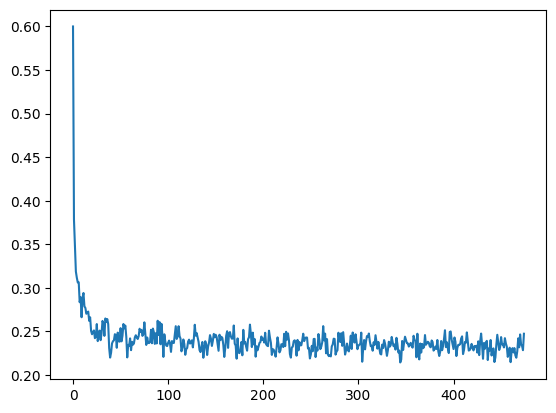

In [85]:
plt.plot(losses[::1000])